In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
from auxPlots import getInfo, getLHEevents, getDistributions, selectColor

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [2]:
#Reading files
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/*/*/*.npz'))
data = []
data_sm = []
#Loading the distributions
for f in files:
    aux = np.load(f, allow_pickle = True)
    if aux['model'] == 'SM':
        data_sm.append(aux)
    else:
        data.append(aux)

data = sorted(data, key=lambda d: d['mass_params'][0])
print(data_sm[2]['process'])
print(data[4]['deltaPhi'], data[5]['model'])

$p p \to t \bar{t}$
[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265] EFT


# Invariant mass

In [139]:
#Generating the numpy histogram for SM:
bins = np.arange(500.,3000.,50.)

labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
    

print(labels_sm)

['$q q \\to t \\bar{t}$ (SM)', '$g g \\to t \\bar{t}$ (SM)', '$p p \\to t \\bar{t}$ (SM)']


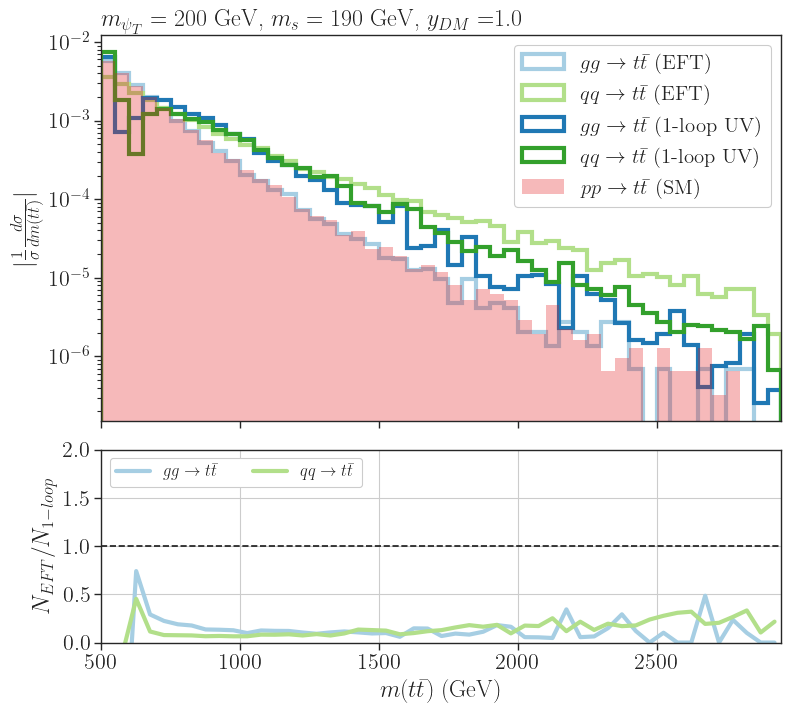

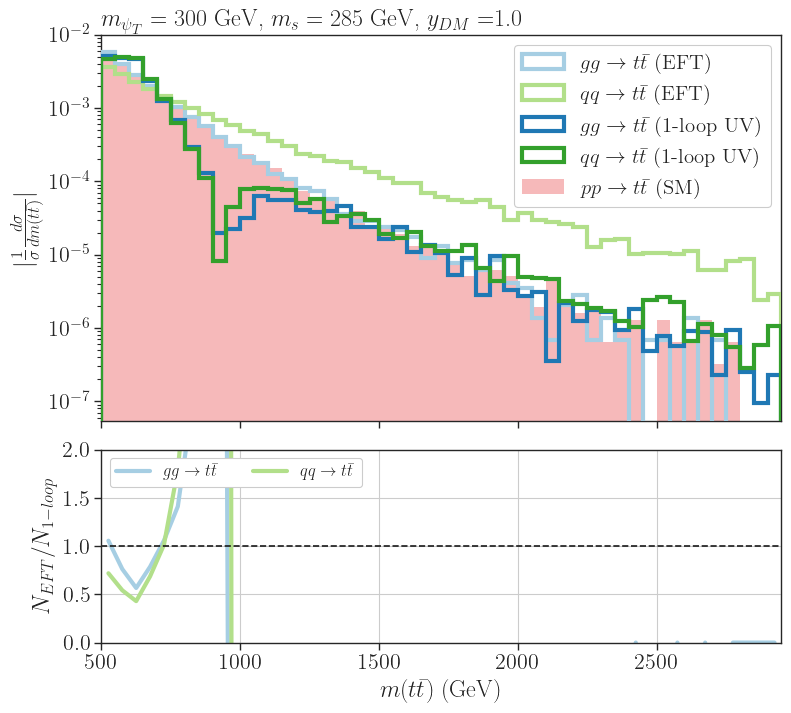

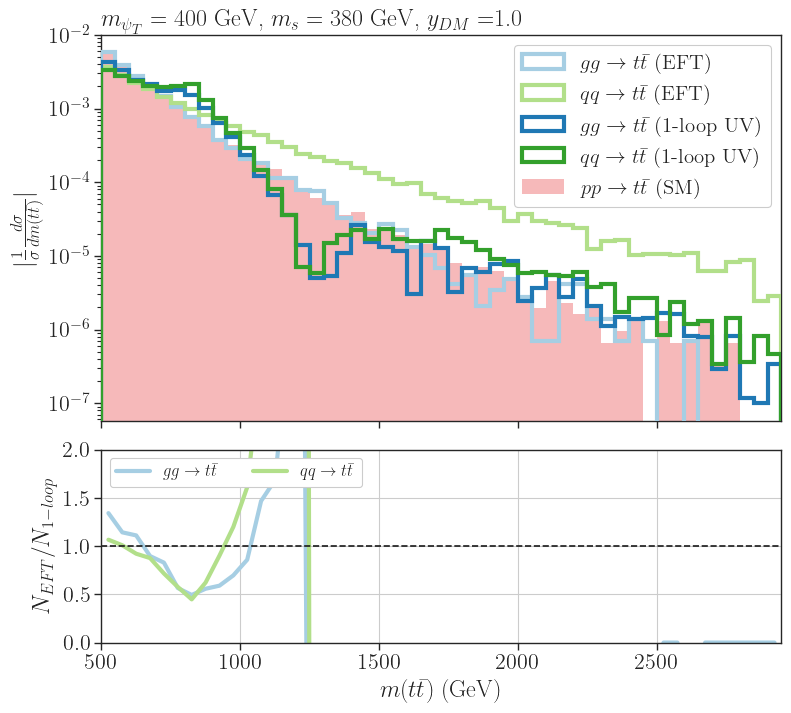

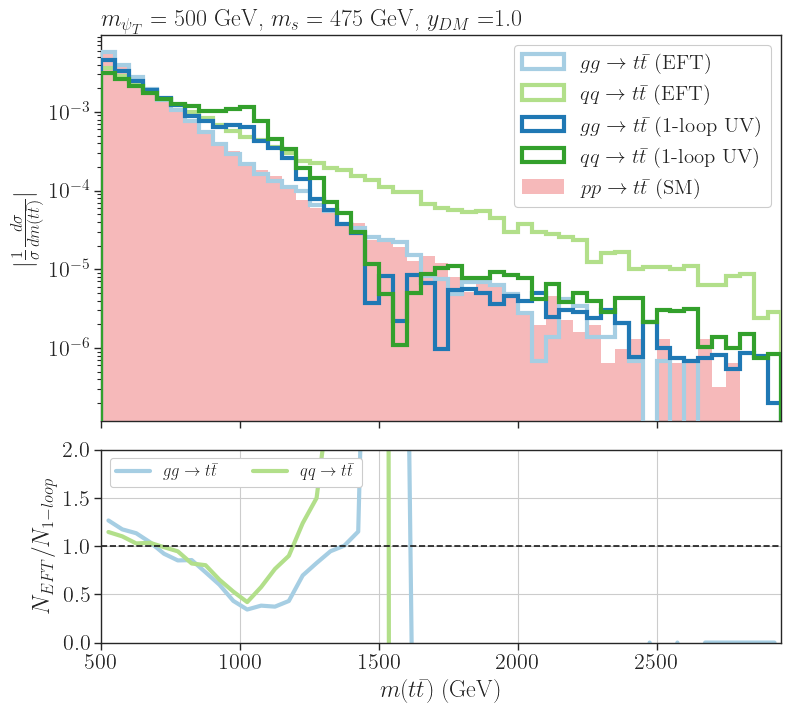

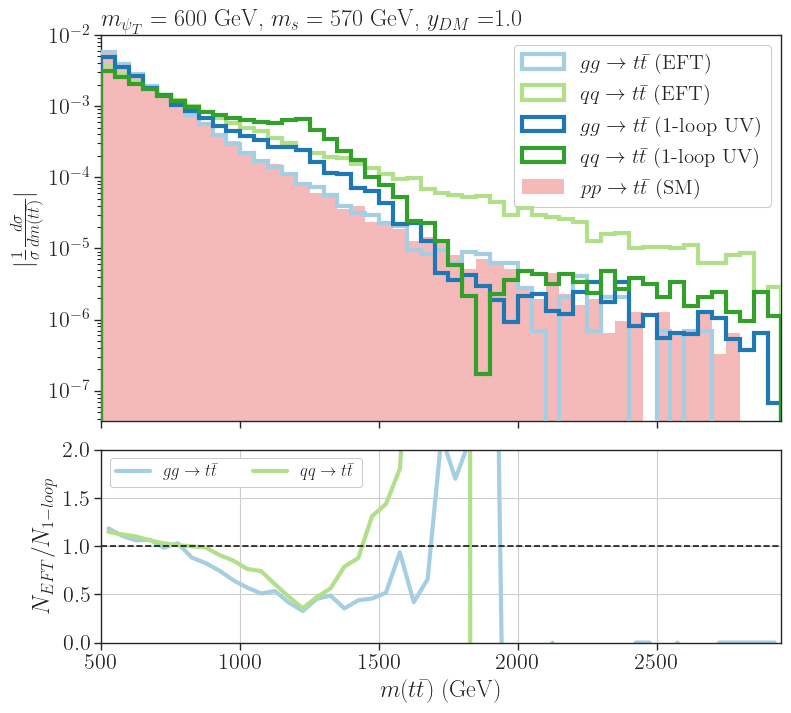

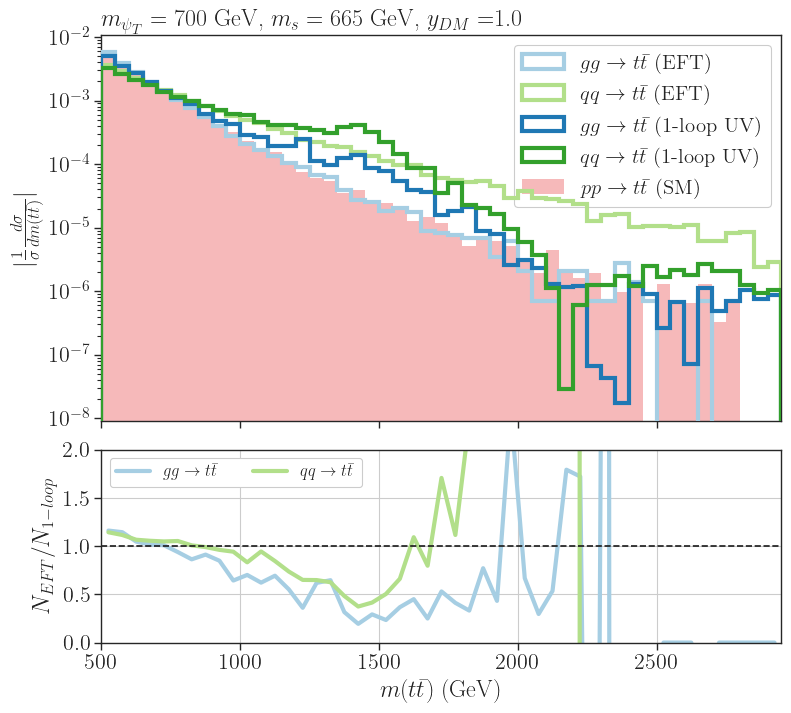

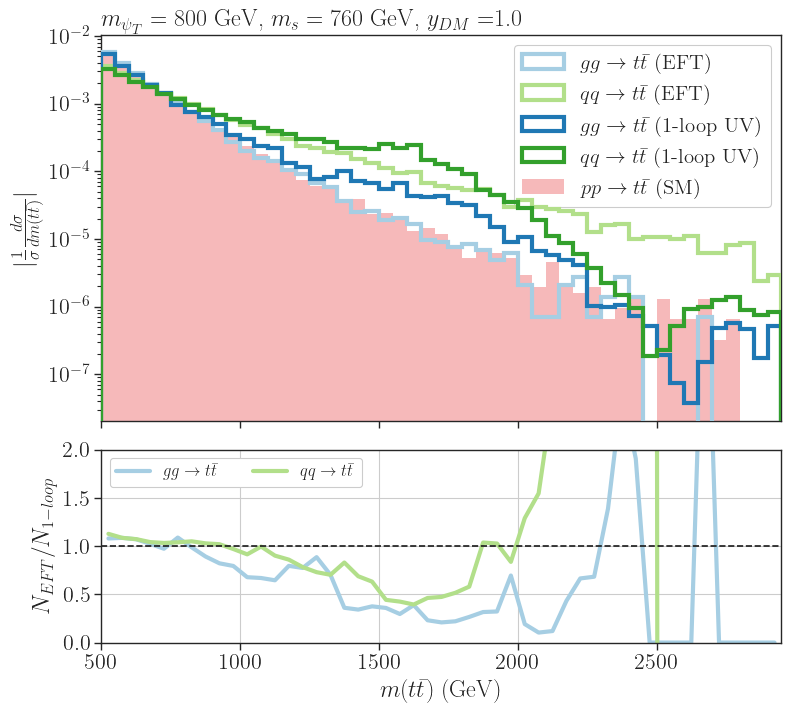

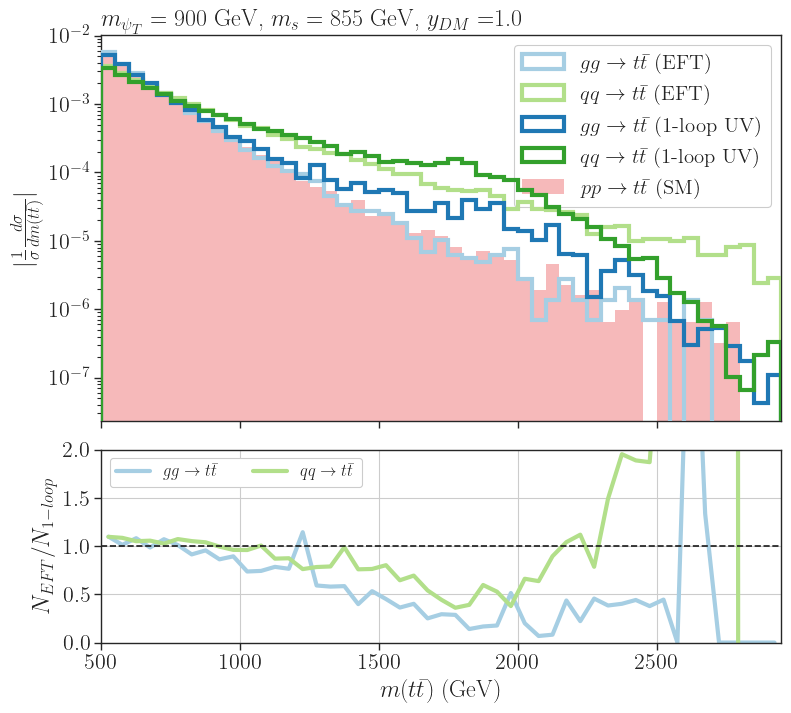

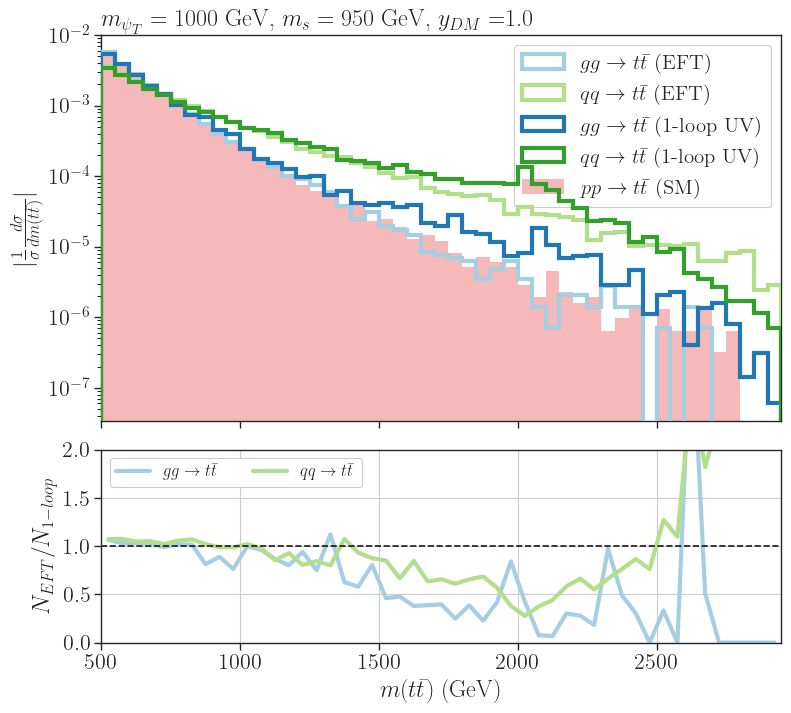

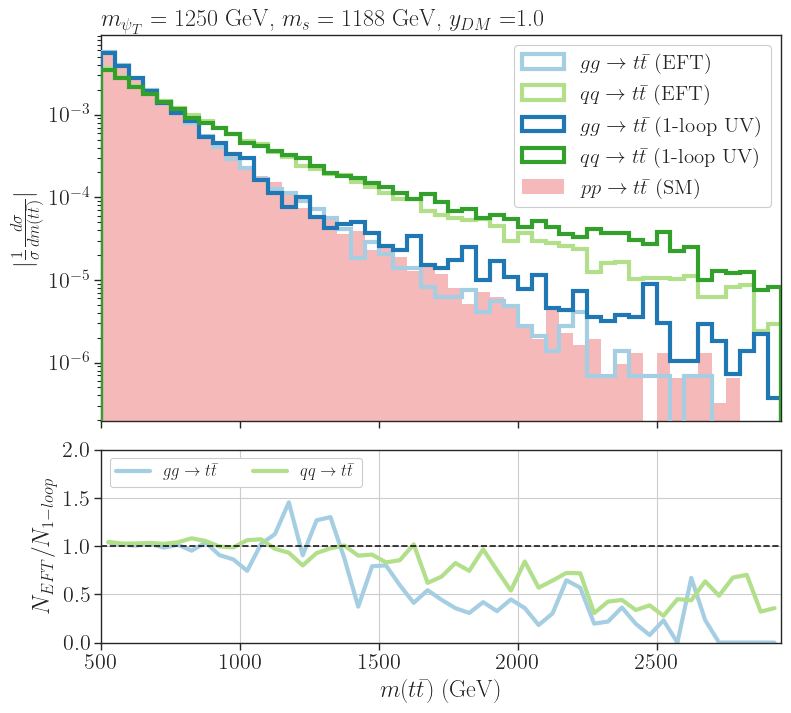

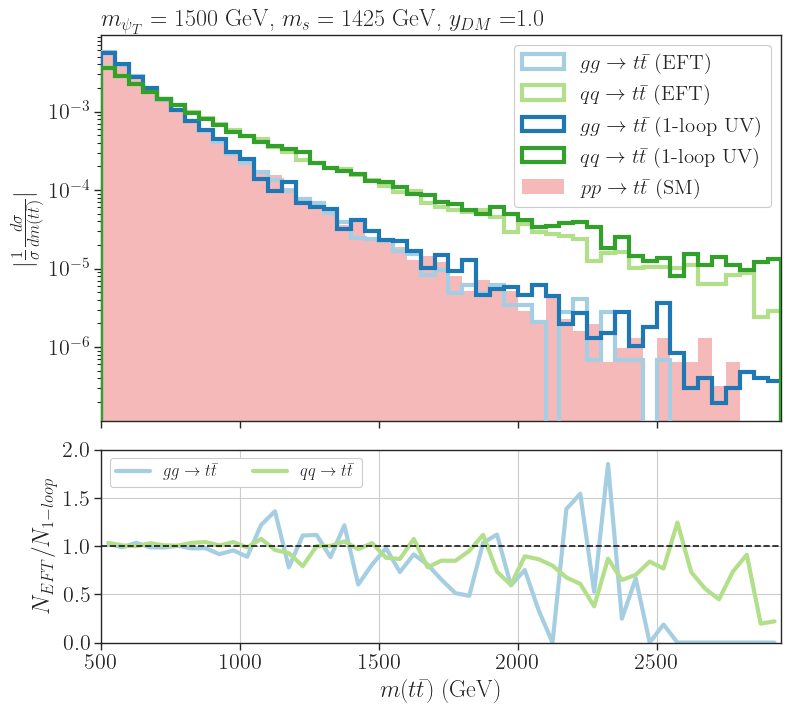

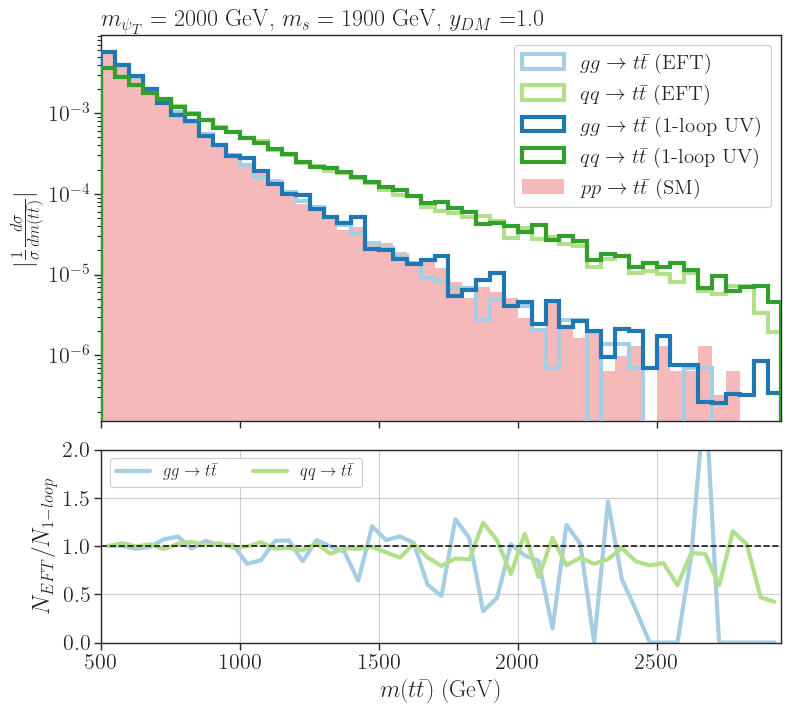

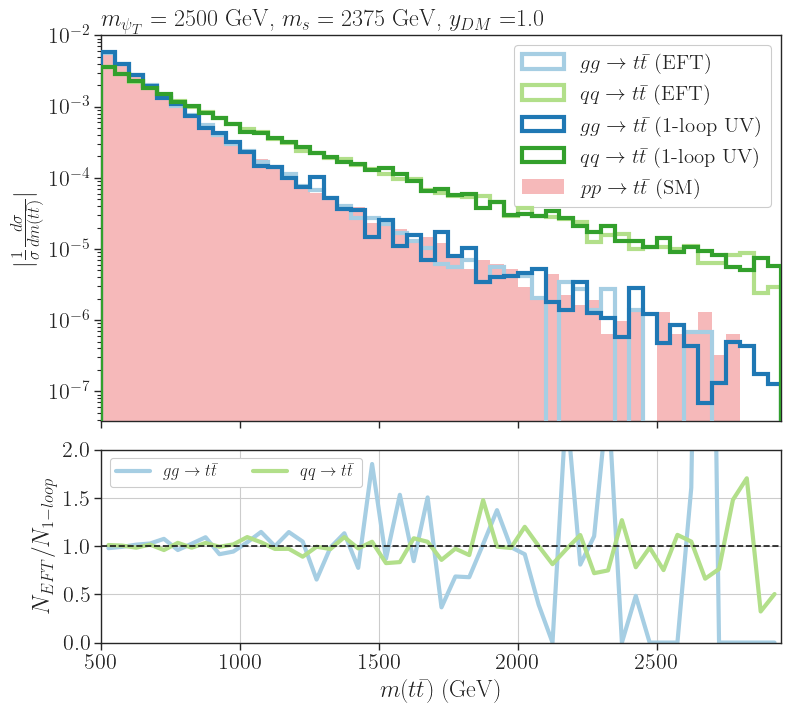

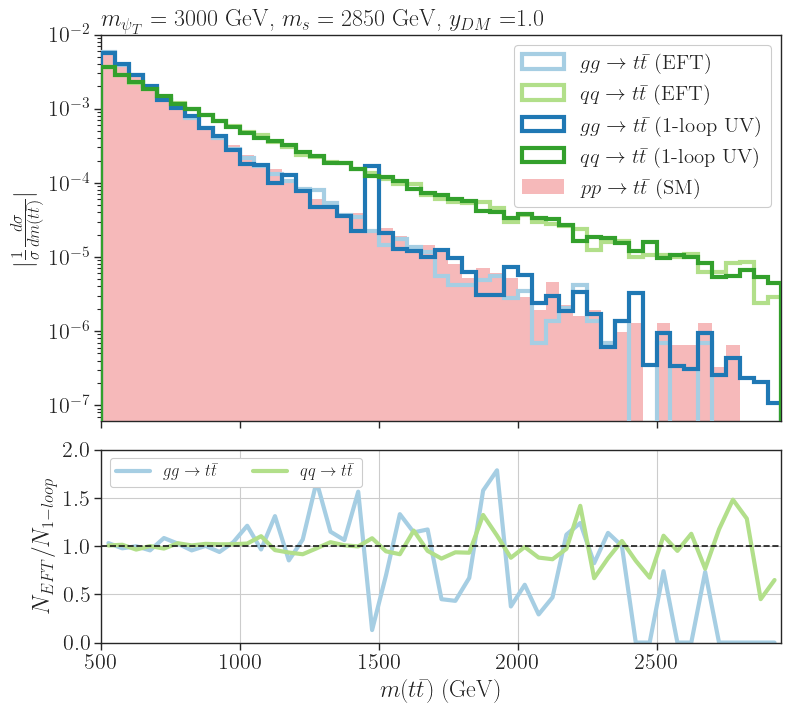

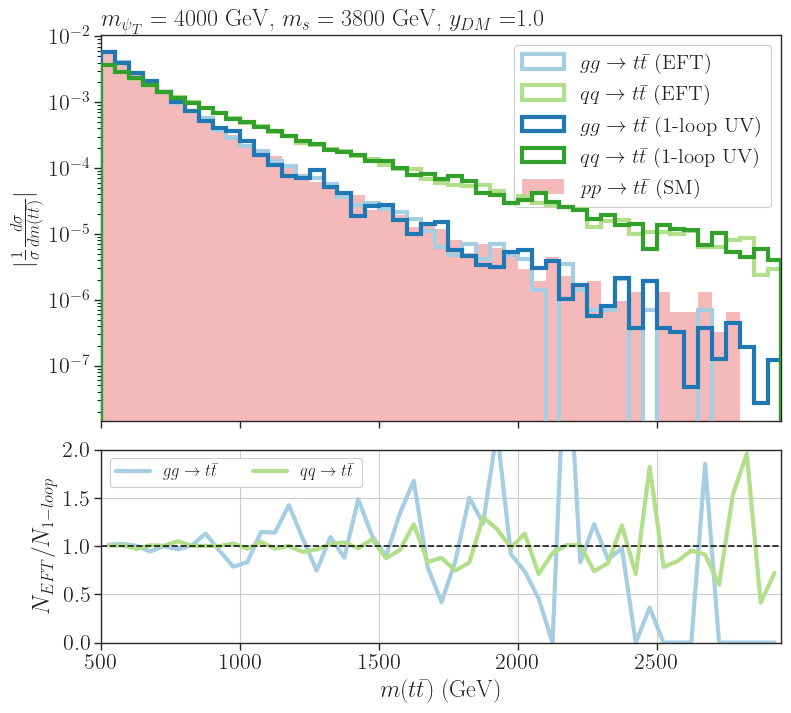

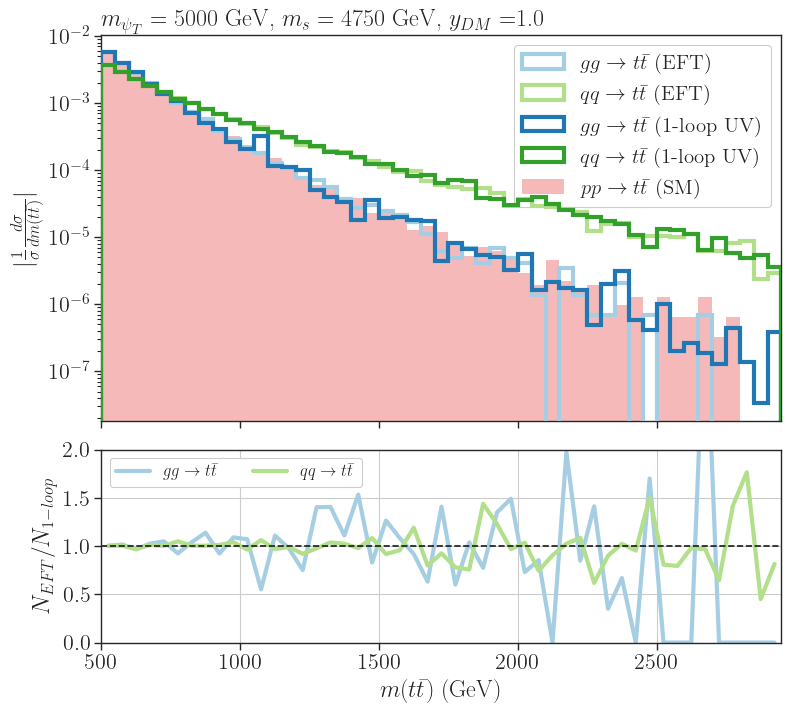

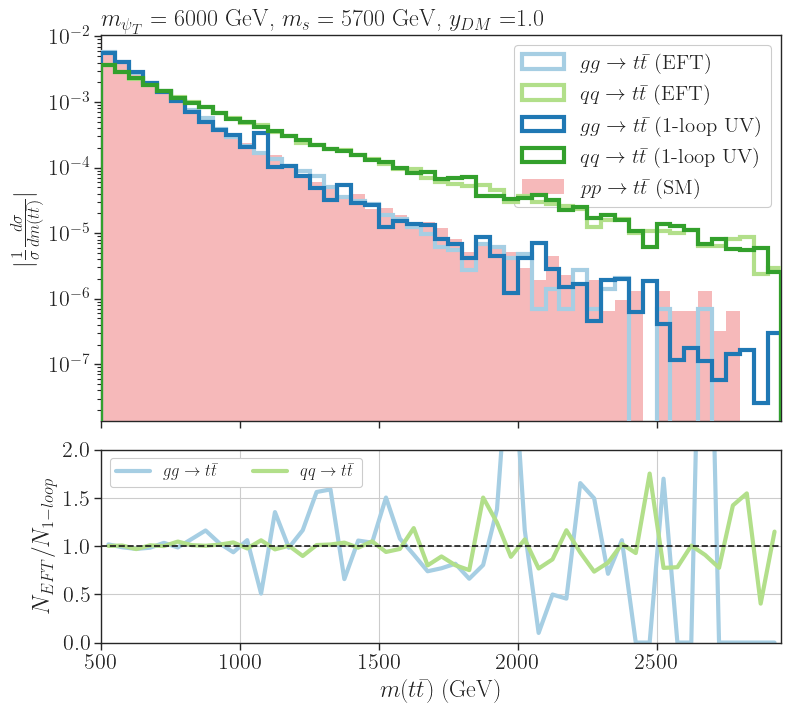

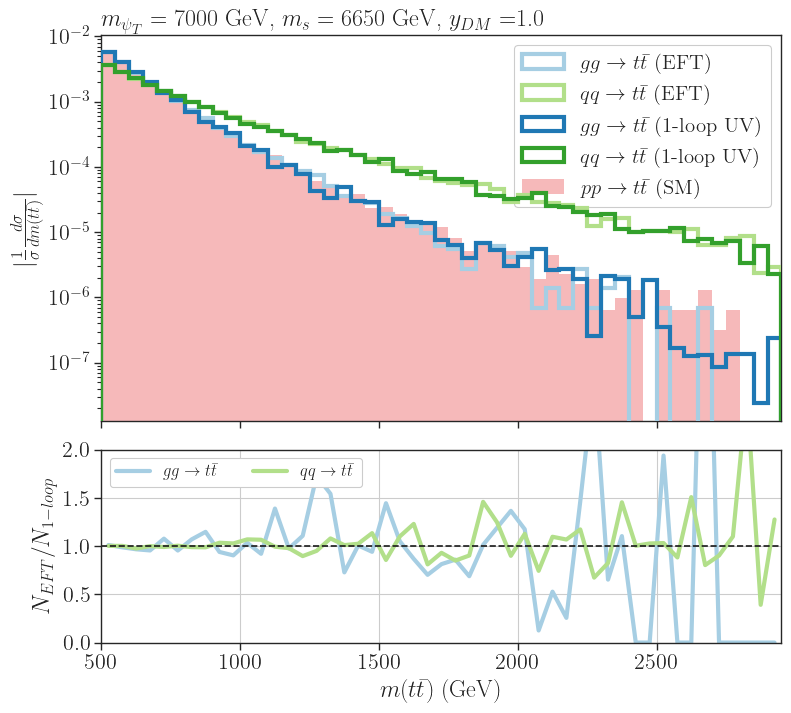

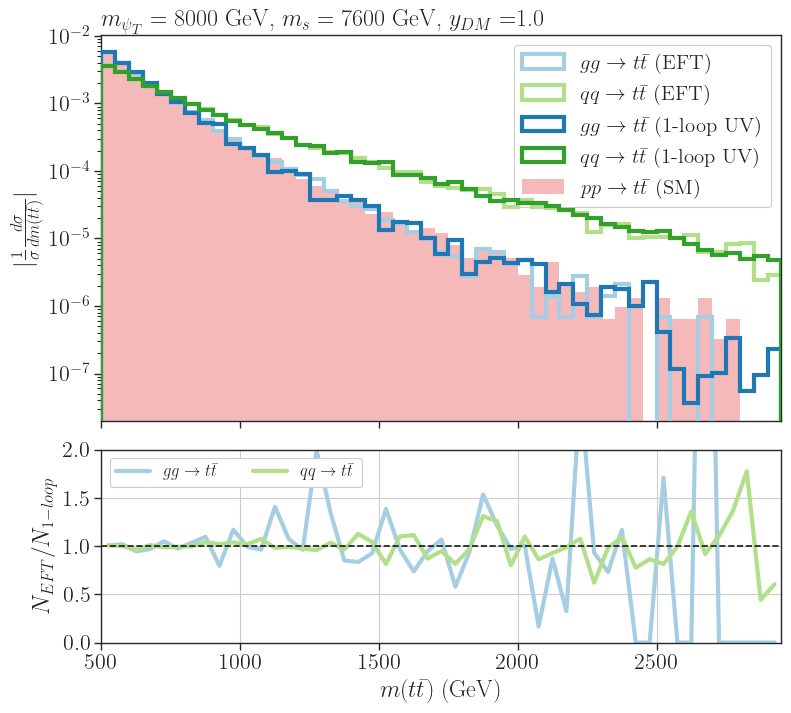

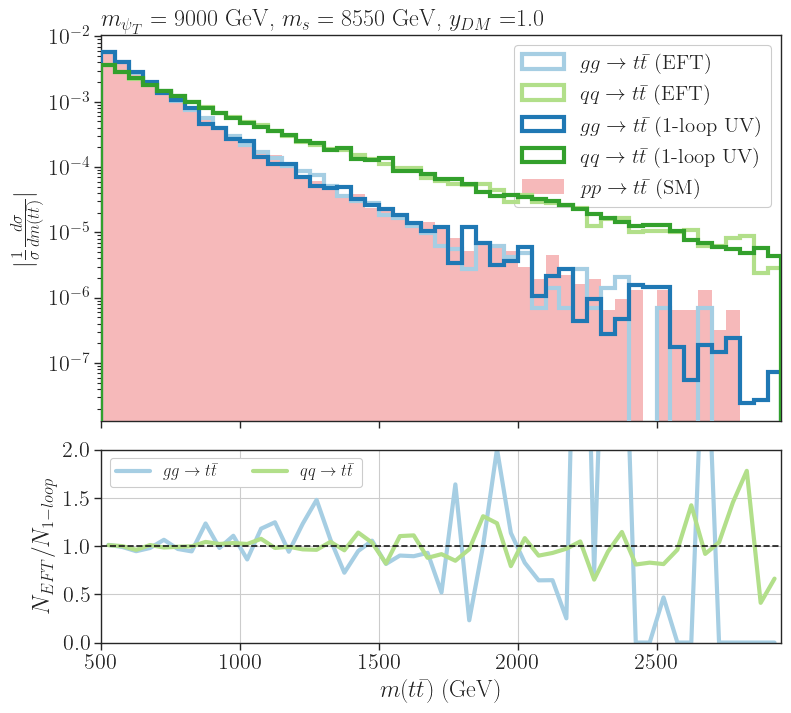

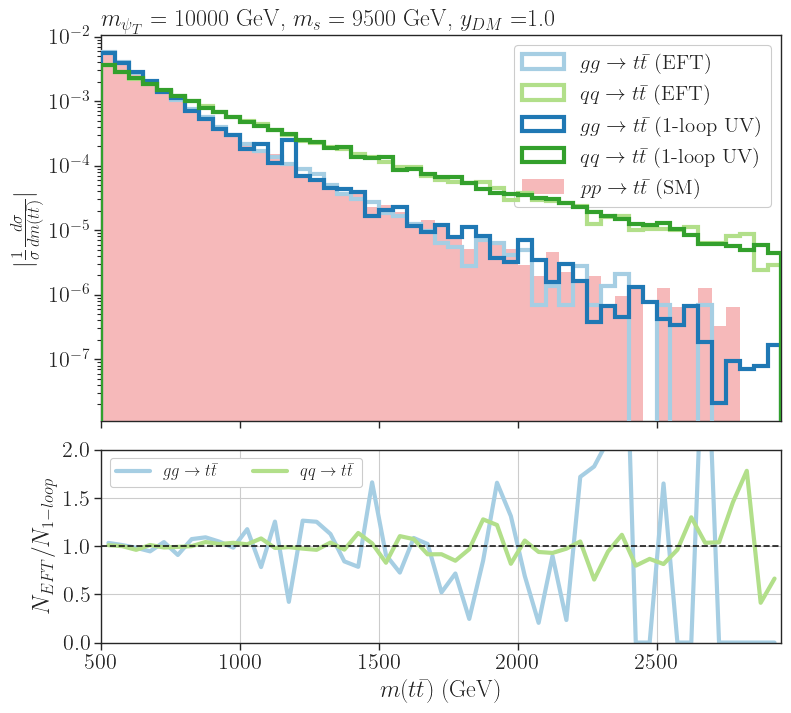

In [145]:
#Generating the BSM histograms and plotting them
bins = np.arange(500.,3000.,50.)
# Coupling value
yDM = 1.0

#Loop over the masses configurations. Each mass configuration has 2 models with 2 processes each
for i in range(0, len(data), 4):
    #Selecting the models and process for the same mass configuration
    selected = data[i : i+4]

    #Defining the space for the two plots 
    _, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

    #Variables used to store hist info
    labels = []
    pmodels = []
    hists = []
    histsErr = []
    c = []
    mPsiT,mSDM = selected[0]['mass_params']

    #Loop over the processes and models
    for j,d in enumerate(selected):
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                          color=c[j],alpha=1.0,histtype='step',density=True,
                         linewidth=3,fill=False,zorder=i,linestyle='solid')
    #Plotting the SM hist
    axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[5],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    #Ratio plot
    # Separating the EFT and the 1-loop UV results
    hLoop = hists[2:]
    hEFT = hists[:2]
    #Computing the ratio EFT/1-loop UV
    labels_r = [r'$g g \to t \bar{t}$', r'$q q \to t \bar{t}$']
    for j,h in enumerate(hLoop):
        ratio = np.divide(hEFT[j]/sum(hEFT[j]) , h/sum(h), out=np.zeros_like(h),where=h != 0)
        #ratio = hEFT[j]- h
        # Remove zero values
        #nonzero = np.where((np.sign(ratio) != 0))
        x = (bins[:-1]+bins[1:])/2.0
        y = ratio
        label = labels_r[j]
        #Ratio plots
        axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[j])
        
    #Main plot configs
    axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
    axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    axarr[0].set_xlim(bins.min(),bins.max())
    axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
    #Subplot configs
    axarr[1].set_ylim(0.0,2)
    #axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
    #axarr[1].set_yscale('log')
    axarr[1].grid()
    axarr[1].axhline(y=1, color='k', linestyle='--')
    axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
    axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

# $p_T$

In [146]:
#Generating the numpy histogram for SM:
bins = np.arange(500.,2000.,100.)

labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
    

print(labels_sm)

['$q q \\to t \\bar{t}$ (SM)', '$g g \\to t \\bar{t}$ (SM)', '$p p \\to t \\bar{t}$ (SM)']


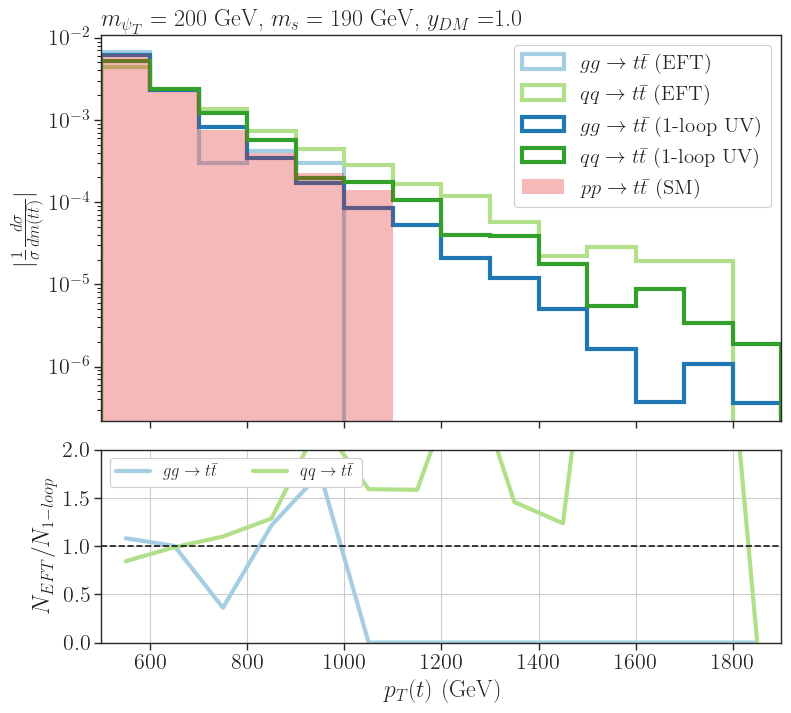

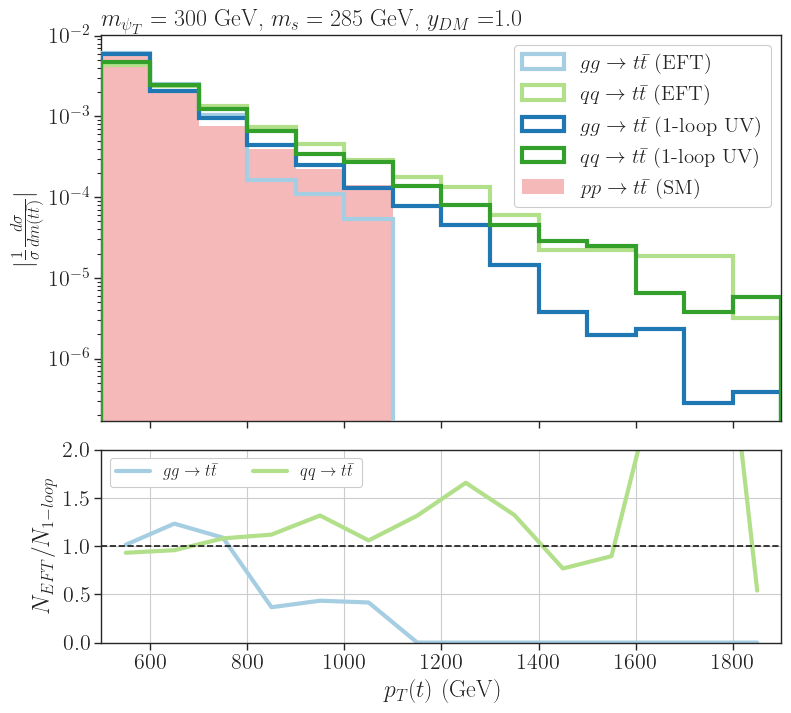

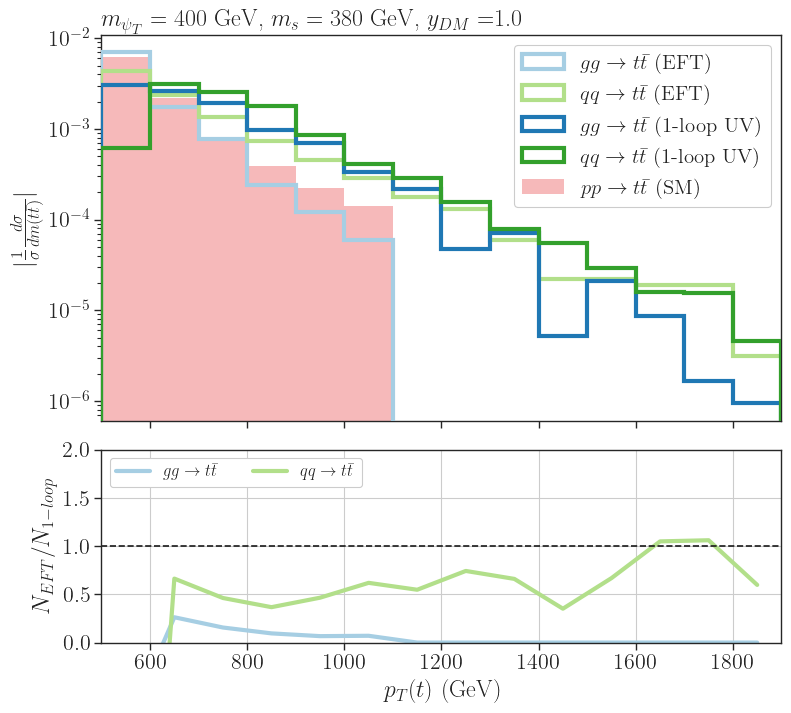

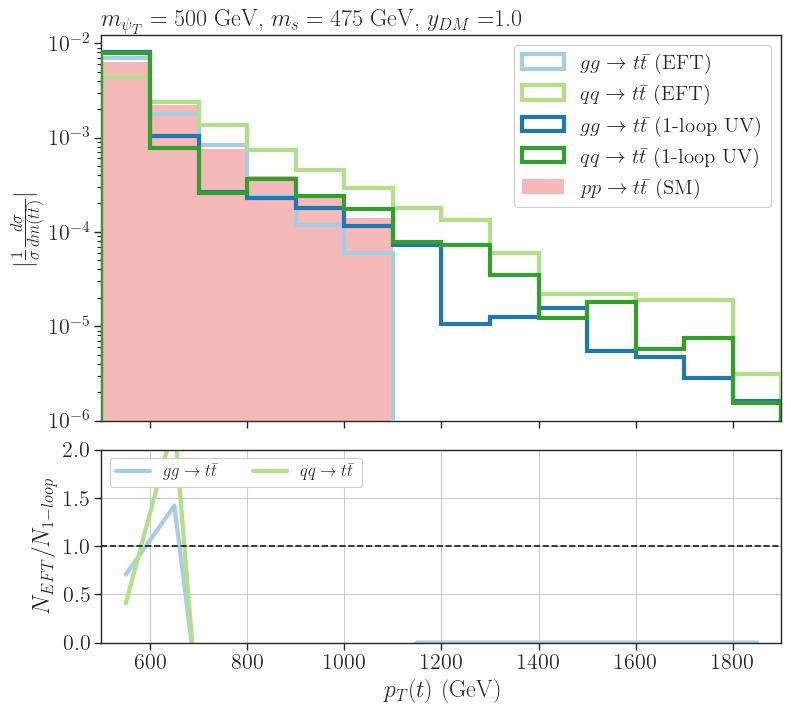

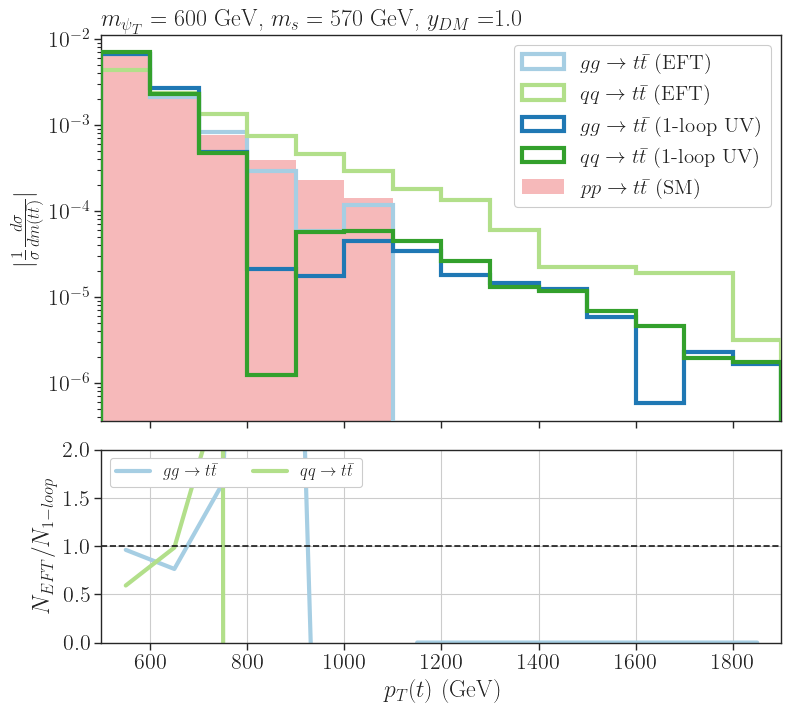

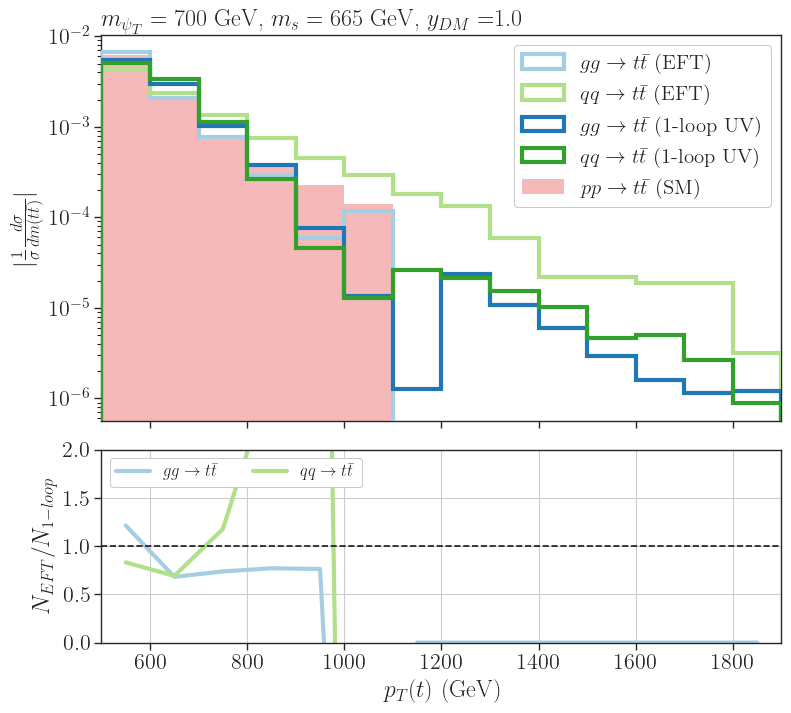

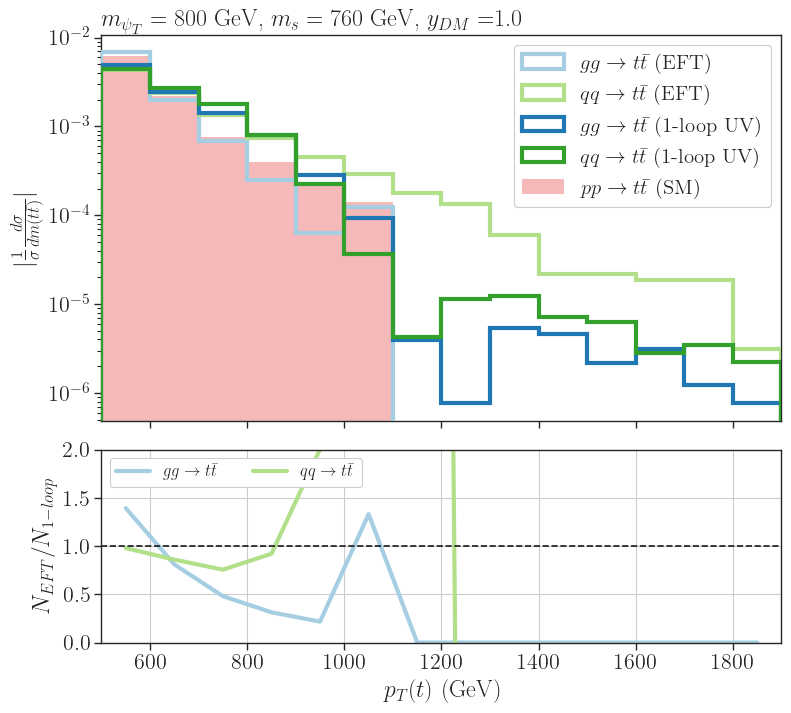

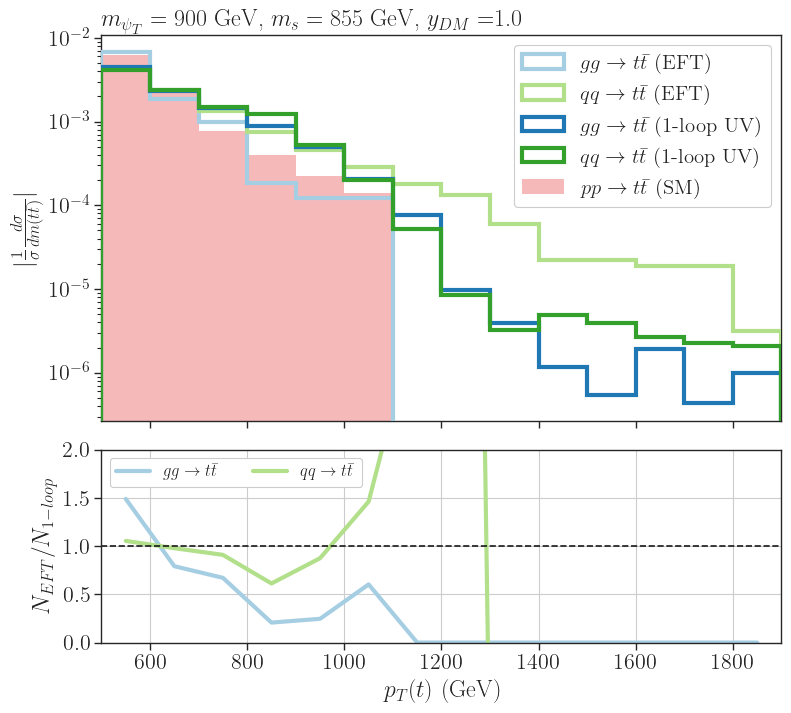

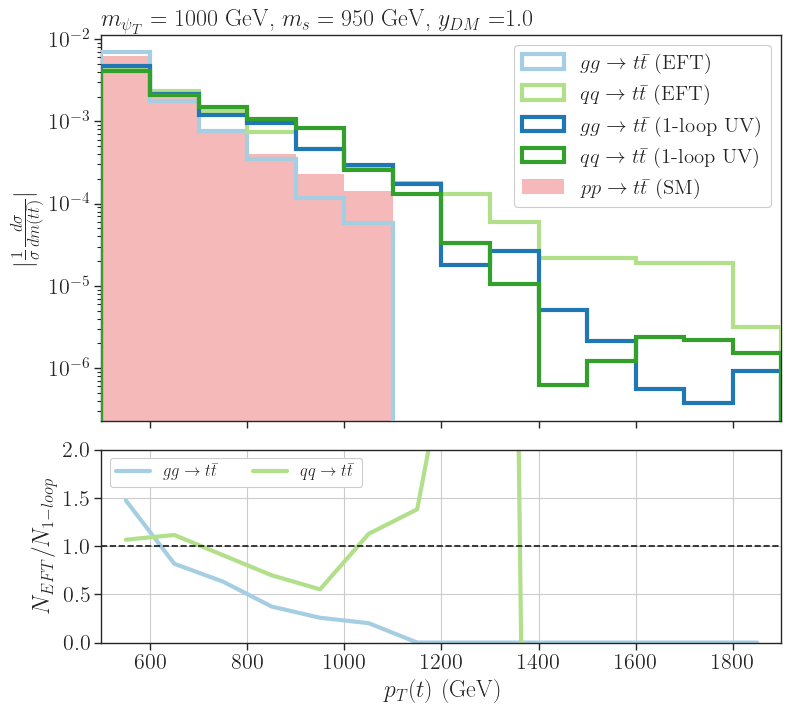

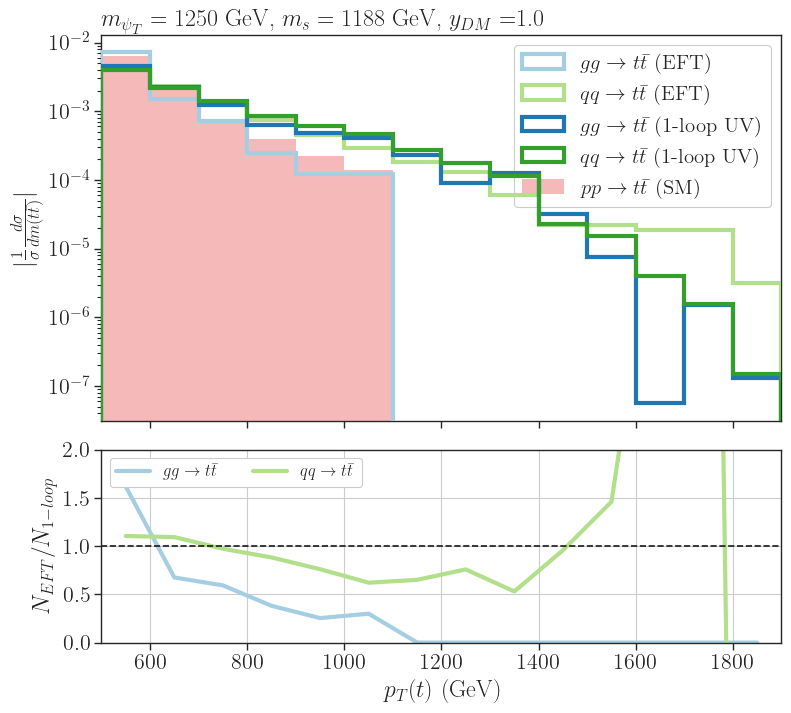

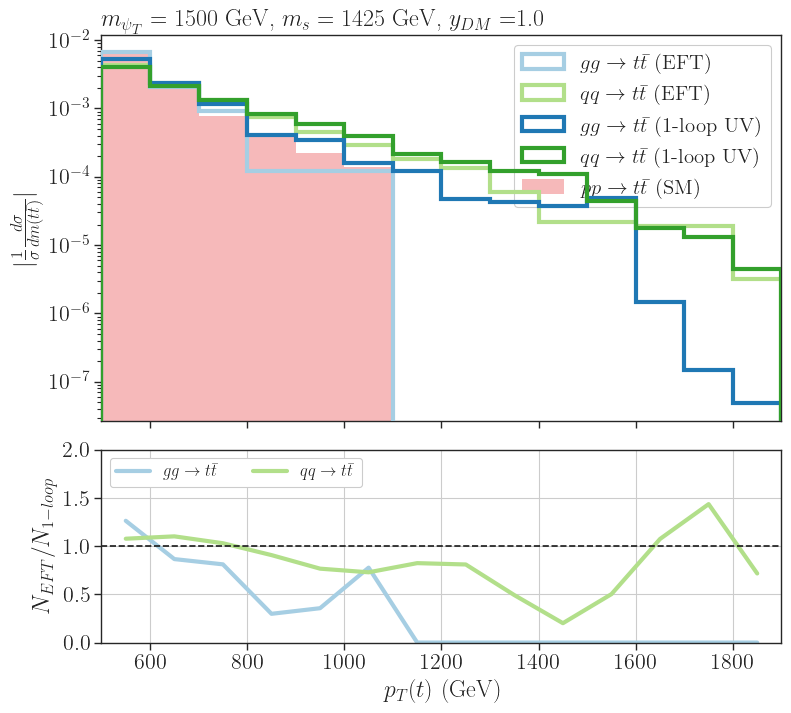

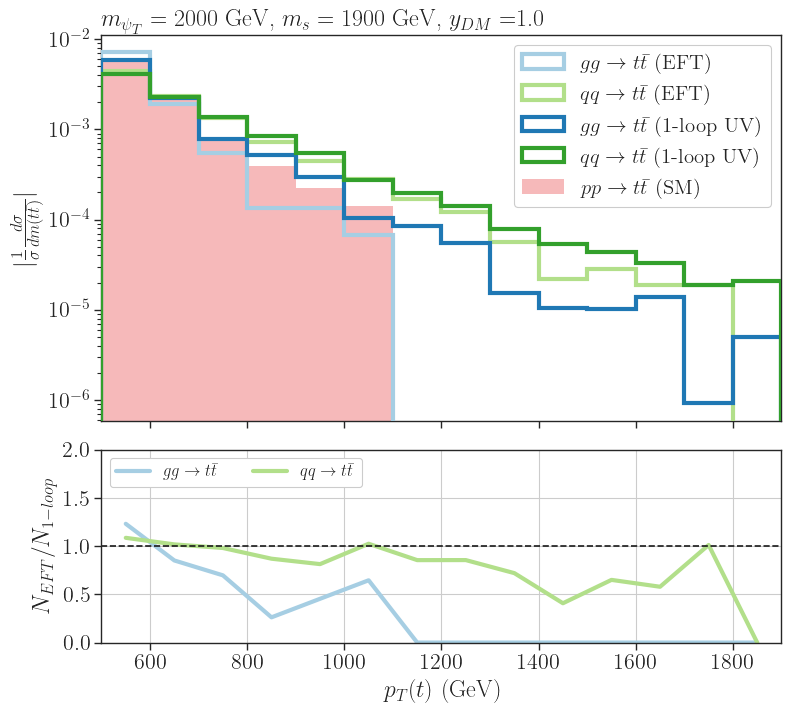

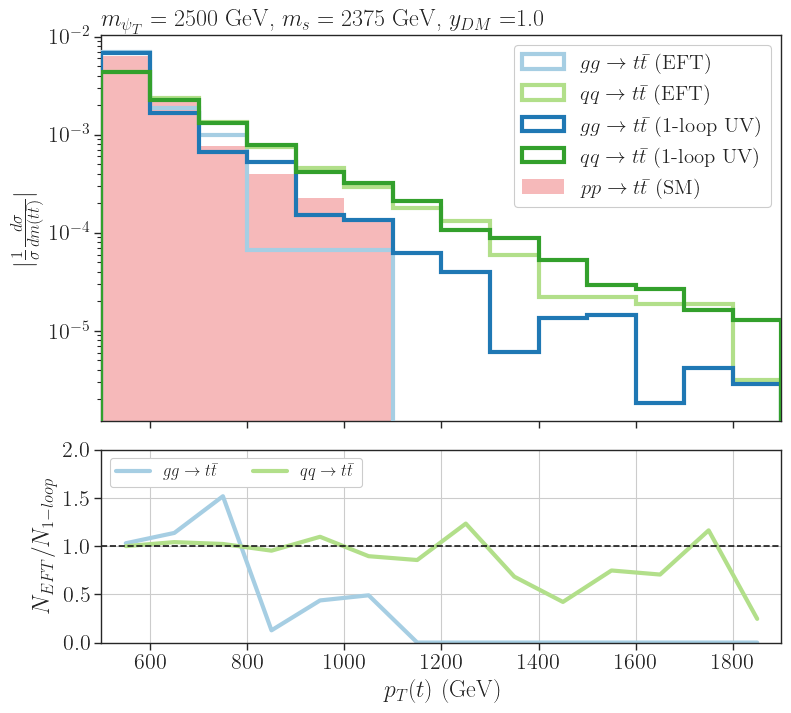

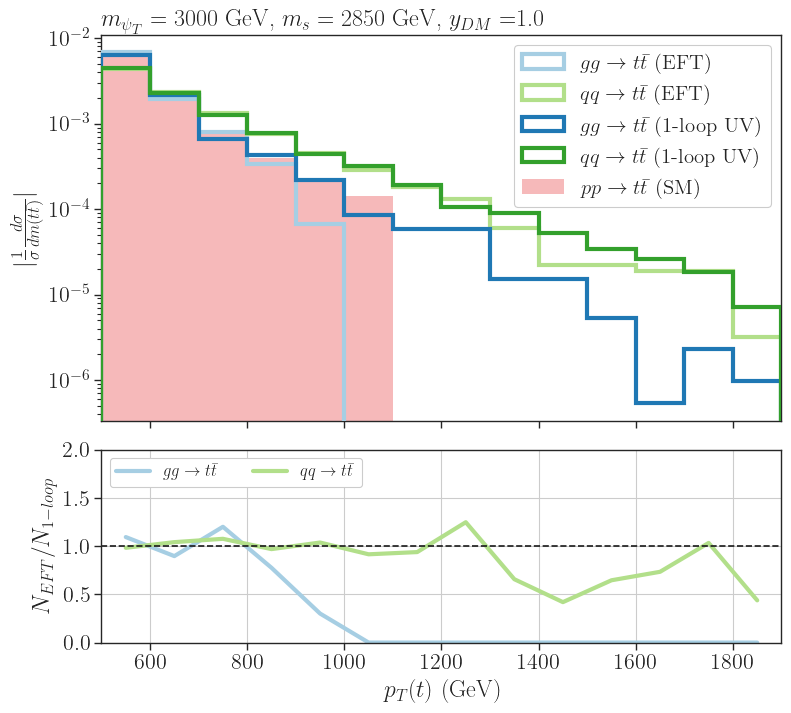

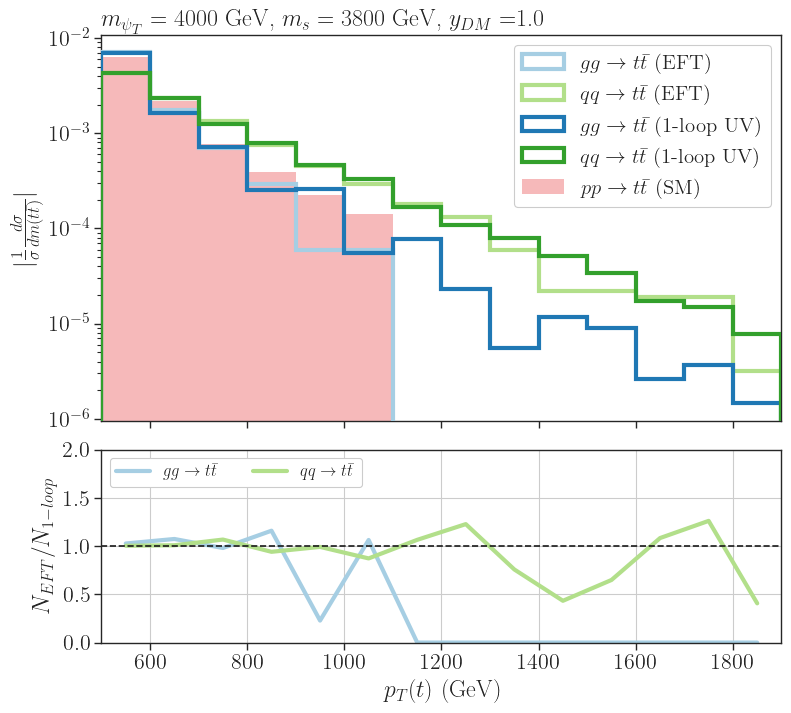

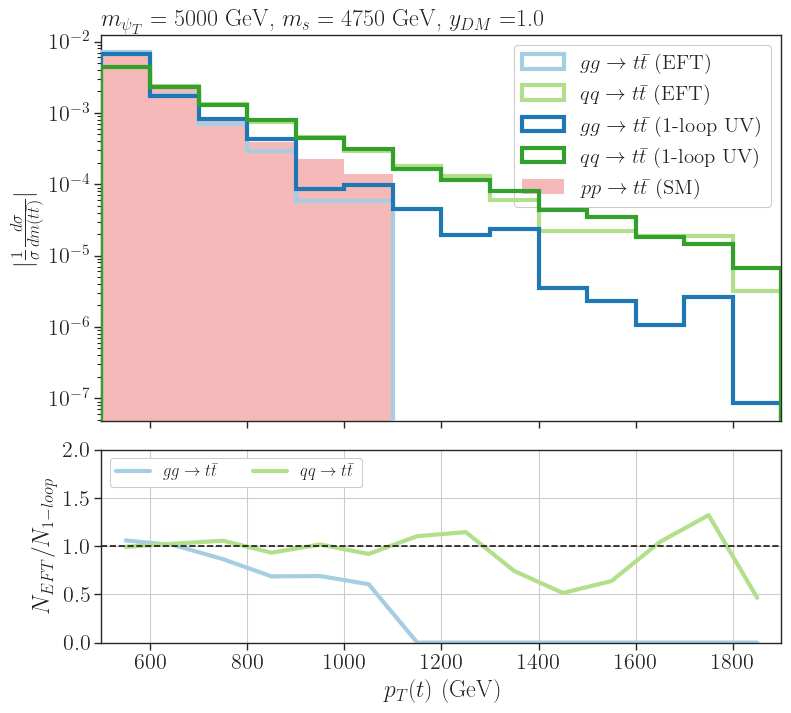

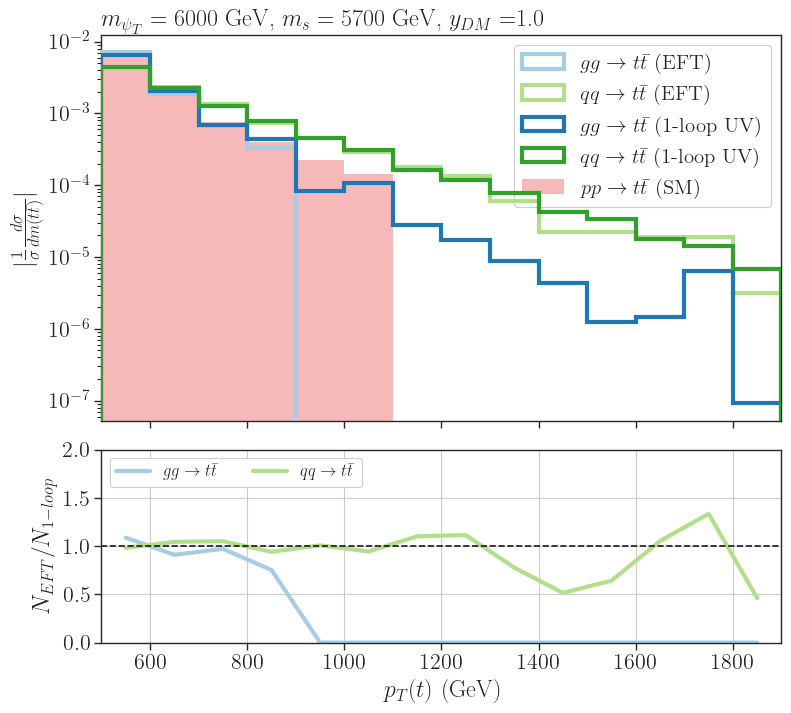

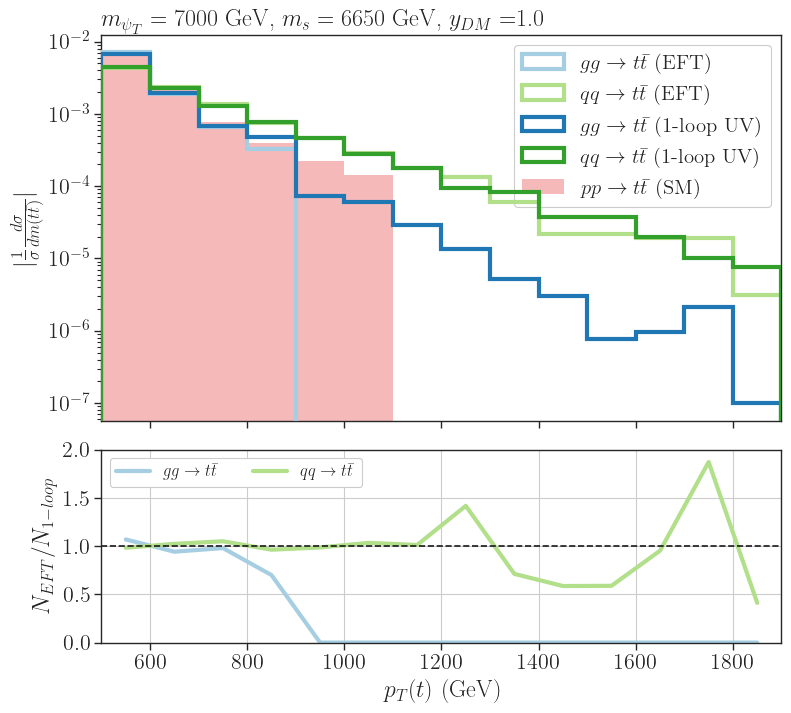

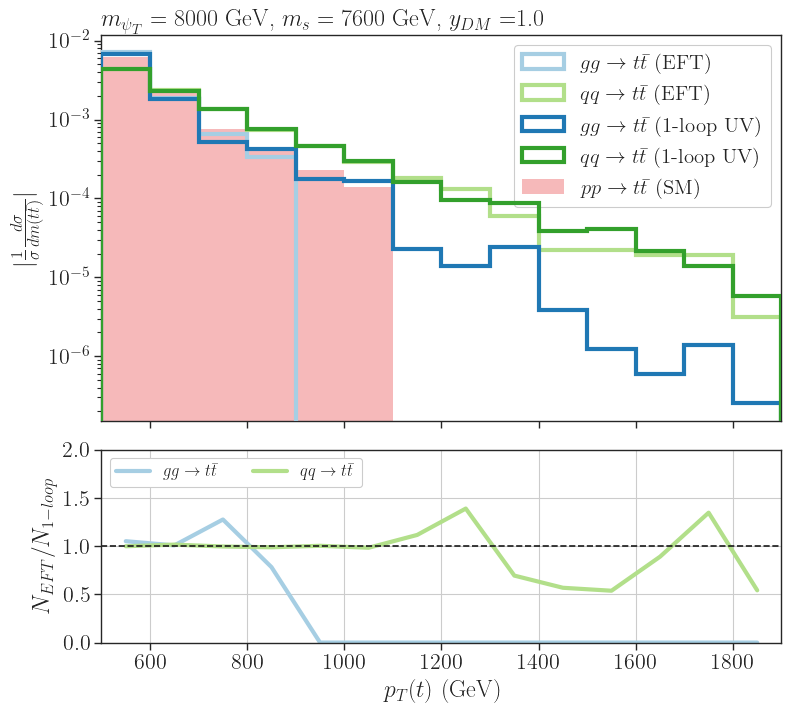

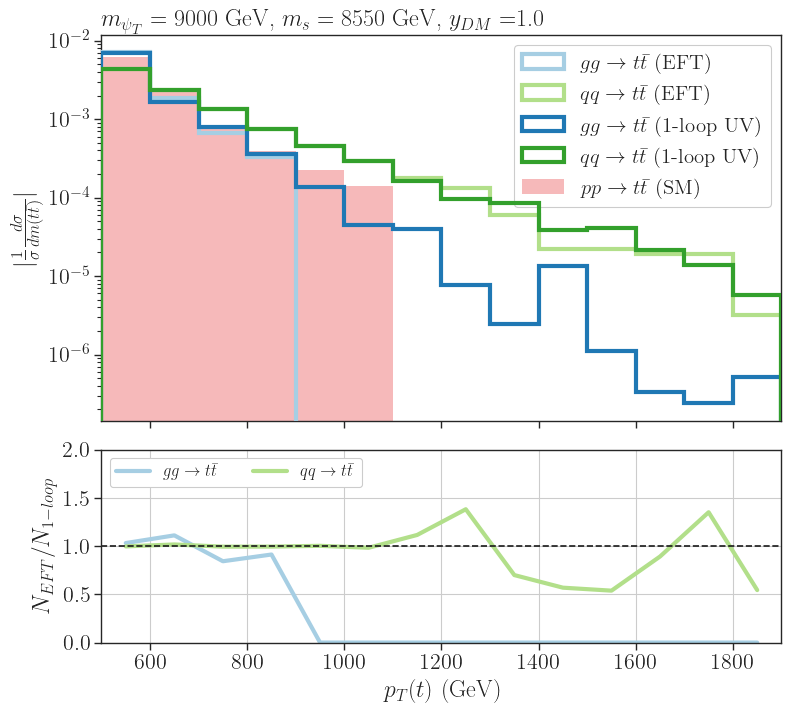

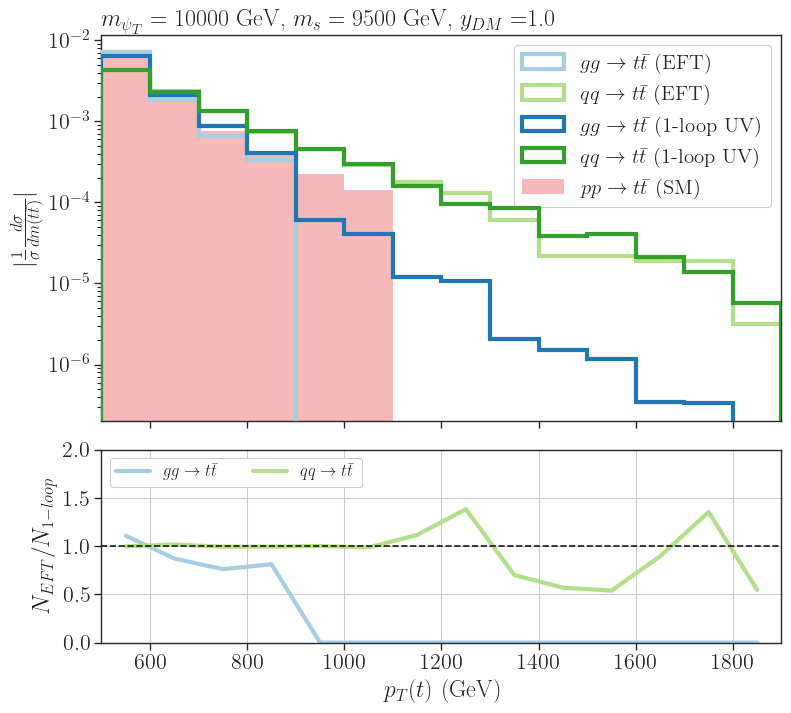

In [147]:
#Generating the BSM histograms and plotting them
bins = np.arange(500.,2000.,100.)
# Coupling value
yDM = 1.0

#Loop over the masses configurations. Each mass configuration has 2 models with 2 processes each
for i in range(0, len(data), 4):
    #Selecting the models and process for the same mass configuration
    selected = data[i : i+4]

    #Defining the space for the two plots 
    _, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

    #Variables used to store hist info
    labels = []
    pmodels = []
    hists = []
    histsErr = []
    c = []
    mPsiT,mSDM = selected[0]['mass_params']

    #Loop over the processes and models
    for j,d in enumerate(selected):
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                          color=c[j],alpha=1.0,histtype='step',density=True,
                         linewidth=3,fill=False,zorder=i,linestyle='solid')
    #Plotting the SM hist
    axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[5],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    #Ratio plot
    # Separating the EFT and the 1-loop UV results
    hLoop = hists[2:]
    hEFT = hists[:2]
    #Computing the ratio EFT/1-loop UV
    labels_r = [r'$g g \to t \bar{t}$', r'$q q \to t \bar{t}$']
    for j,h in enumerate(hLoop):
        ratio = np.divide(hEFT[j]/sum(hEFT[j]) , h/sum(h), out=np.zeros_like(h),where=h != 0)
        #ratio = hEFT[j]- h
        # Remove zero values
        #nonzero = np.where((np.sign(ratio) != 0))
        x = (bins[:-1]+bins[1:])/2.0
        y = ratio
        label = labels_r[j]
        #Ratio plots
        axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[j])
        
    #Main plot configs
    axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
    axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    axarr[0].set_xlim(bins.min(),bins.max())
    axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
    #Subplot configs
    axarr[1].set_ylim(0.0,2)
    #axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
    #axarr[1].set_yscale('log')
    axarr[1].grid()
    axarr[1].axhline(y=1, color='k', linestyle='--')
    axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
    axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
    
plt.show()

# $\Delta\varphi$

In [156]:
#Generating the numpy histogram for SM:
bins = np.arange(0,np.pi,0.5)

labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['deltaPhi'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['deltaPhi'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
    

print(labels_sm)

['$q q \\to t \\bar{t}$ (SM)', '$g g \\to t \\bar{t}$ (SM)', '$p p \\to t \\bar{t}$ (SM)']


/tmp/ipykernel_4666/138008329.py:54: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(hEFT[j]/sum(hEFT[j]) , h/sum(h), out=np.zeros_like(h),where=h != 0)
/tmp/ipykernel_4666/138008329.py:69: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axarr[0].set_yscale('log')


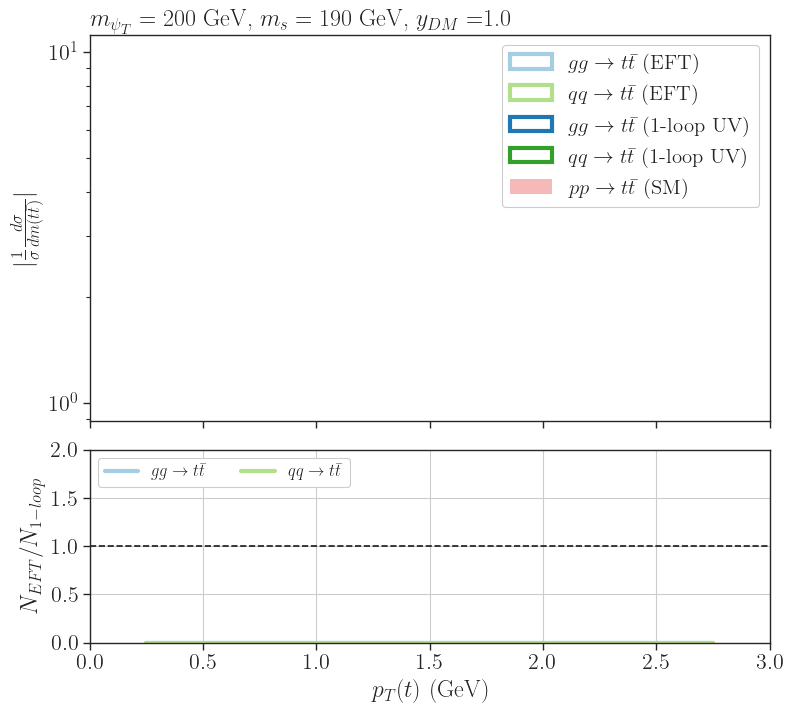

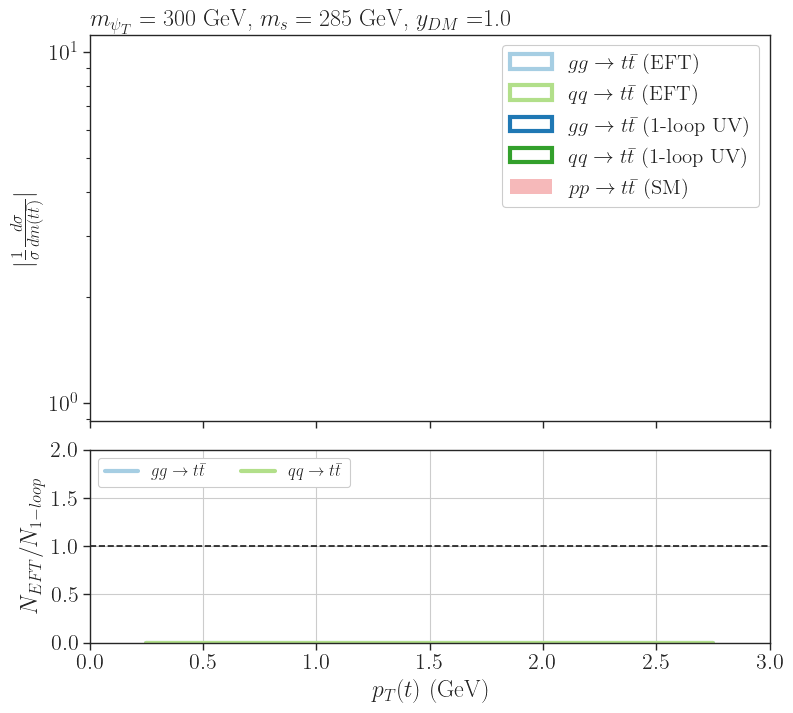

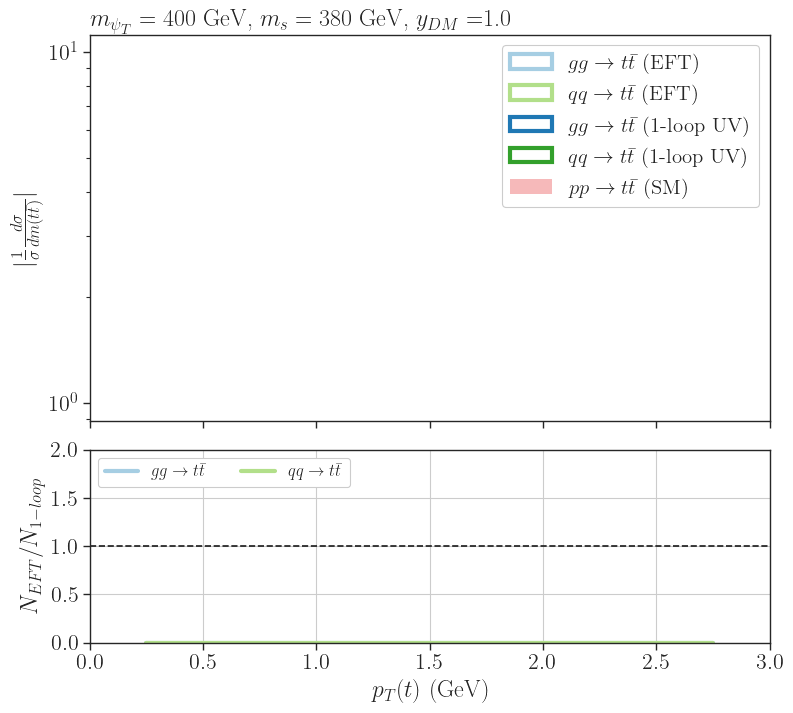

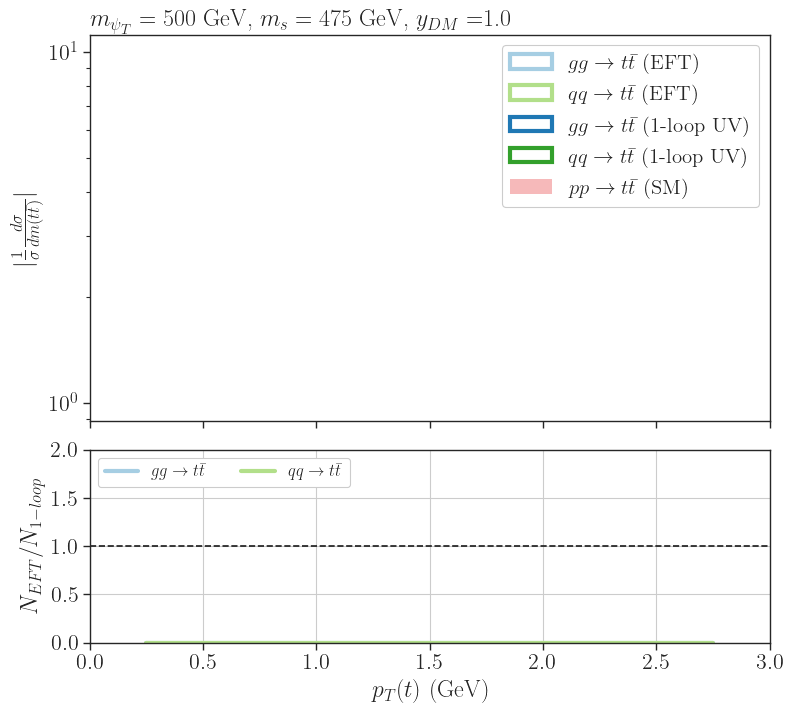

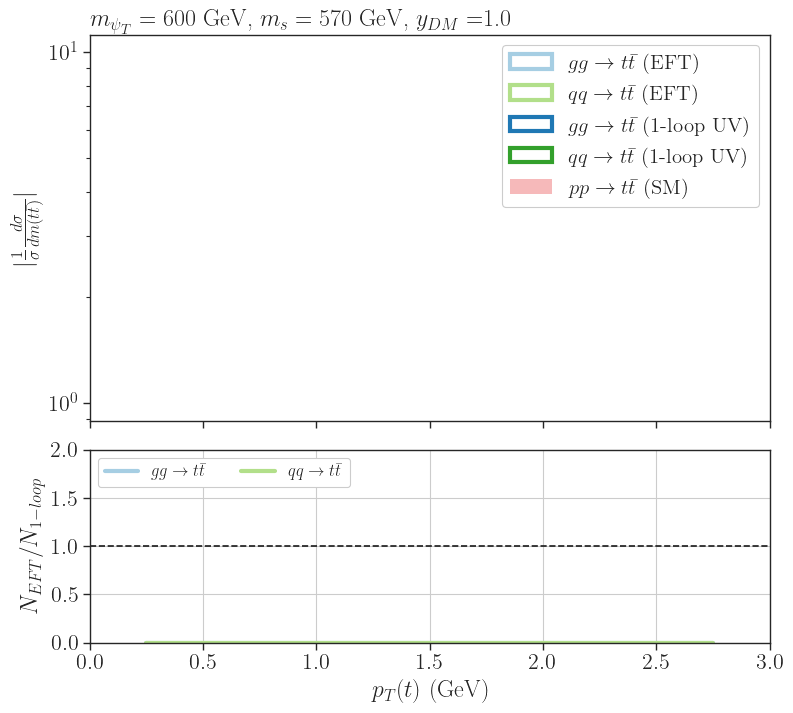

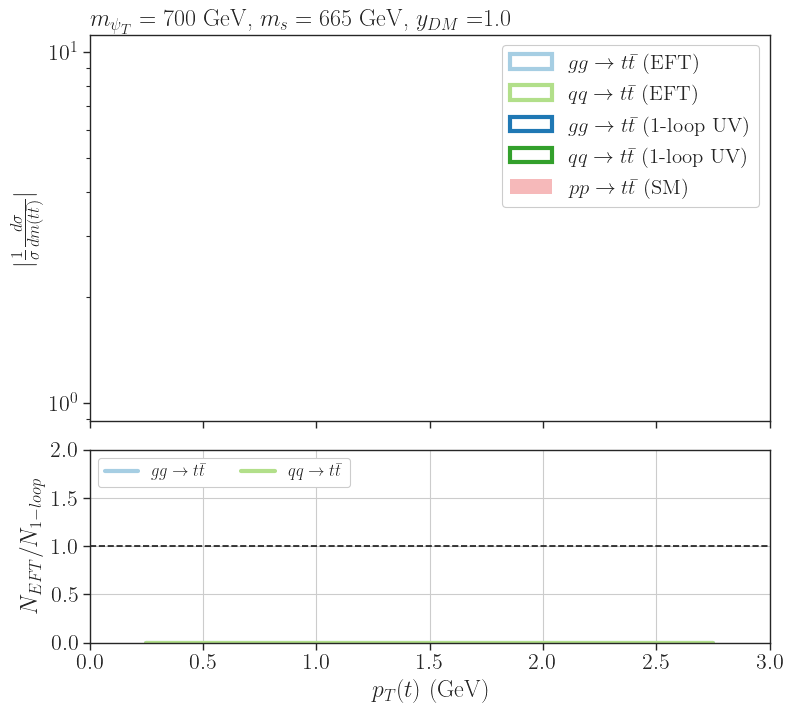

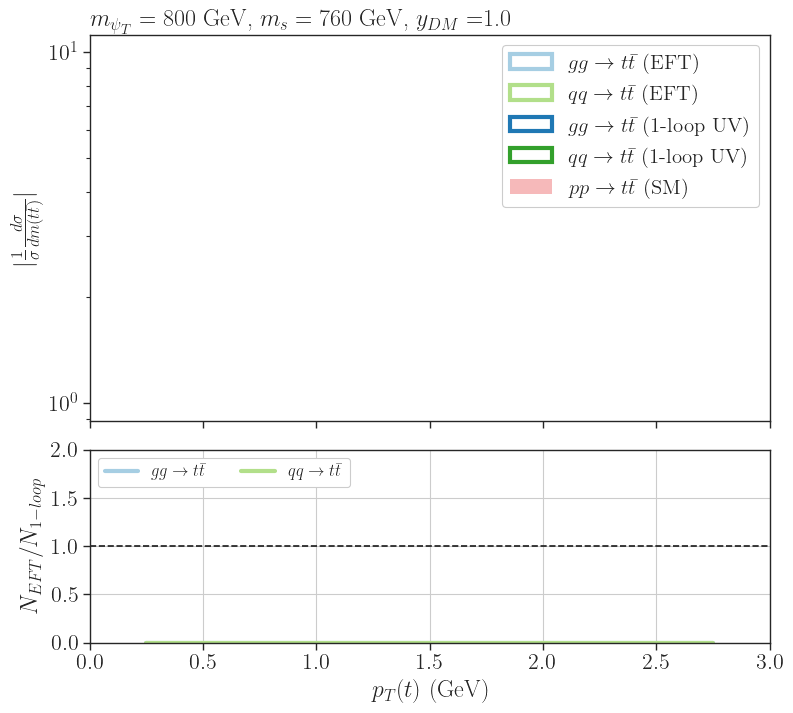

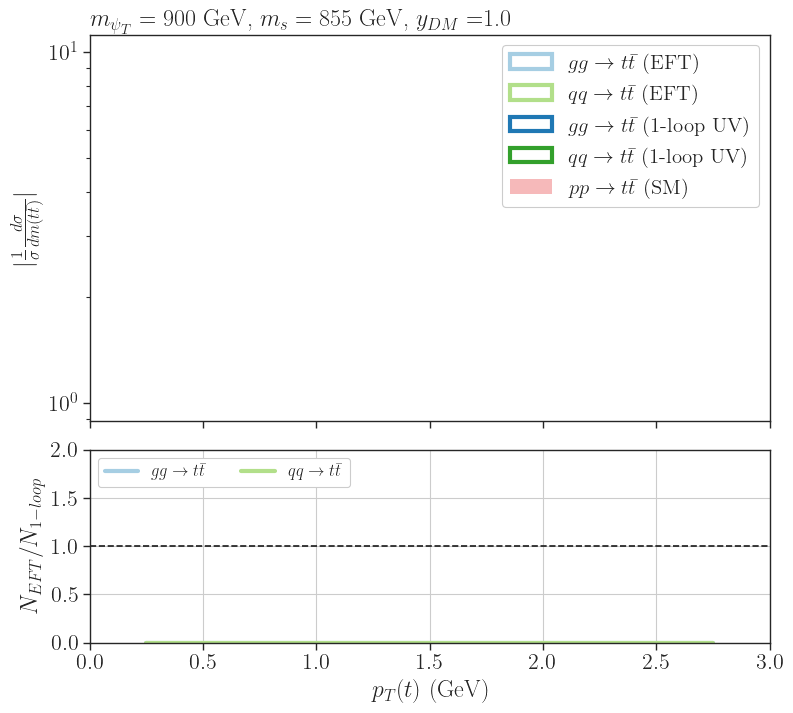

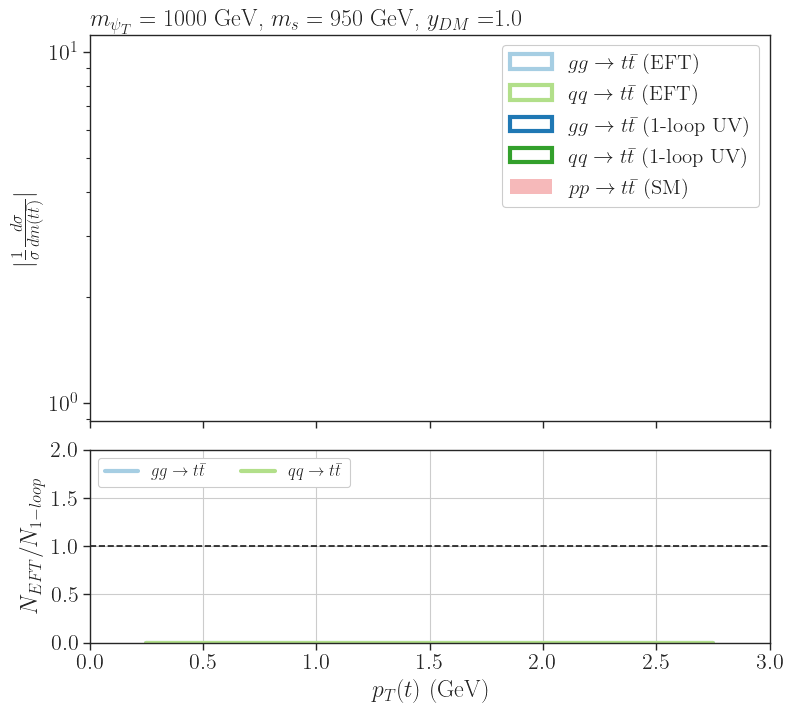

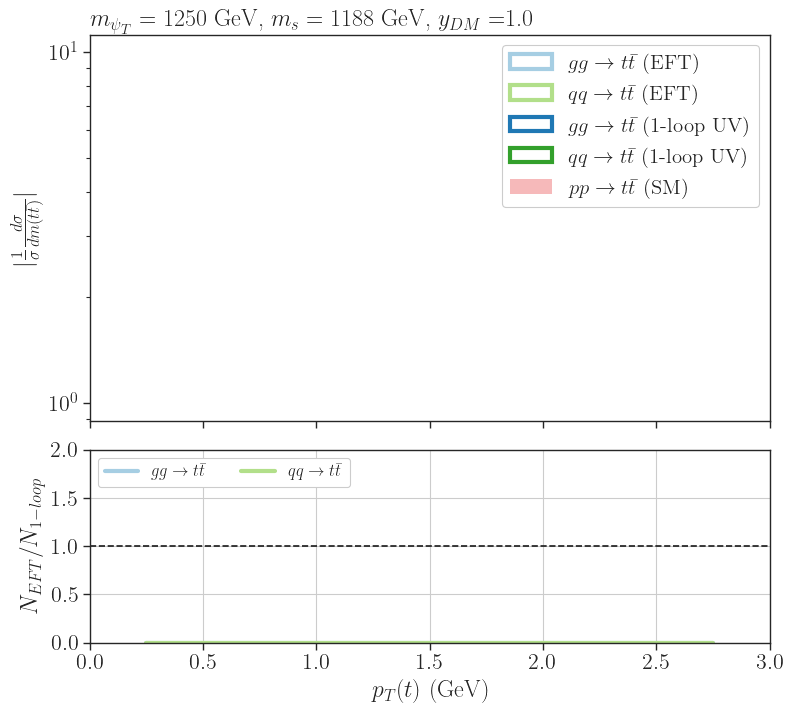

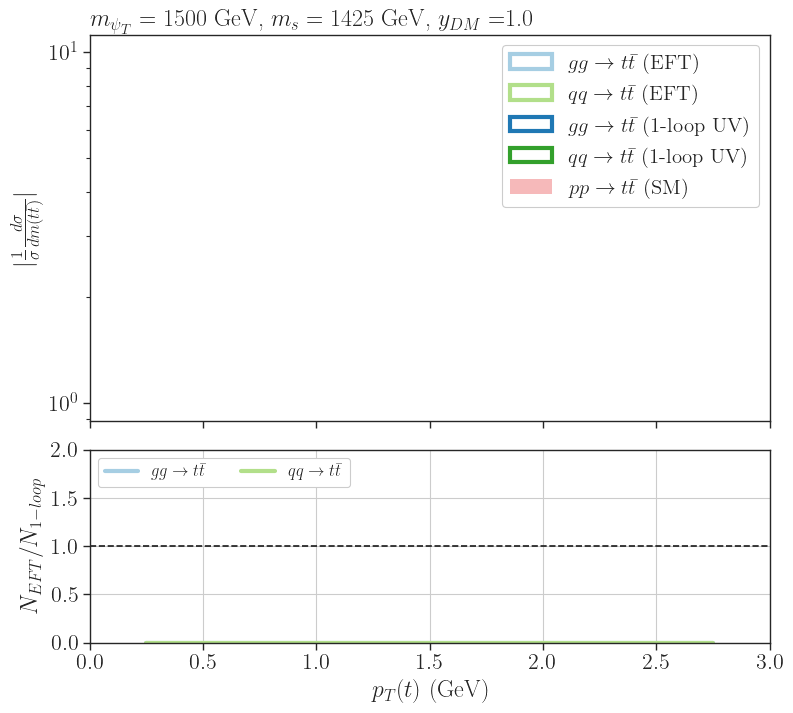

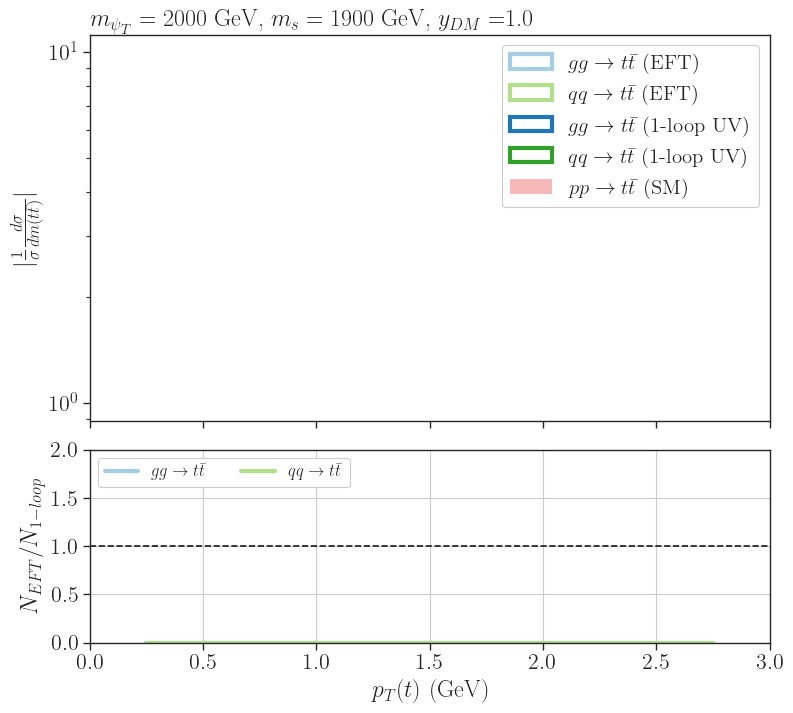

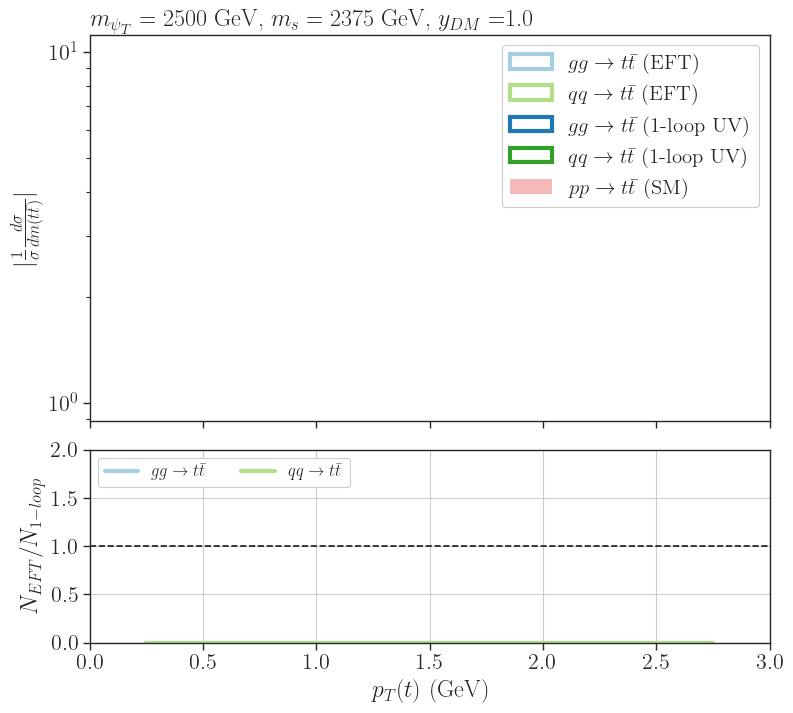

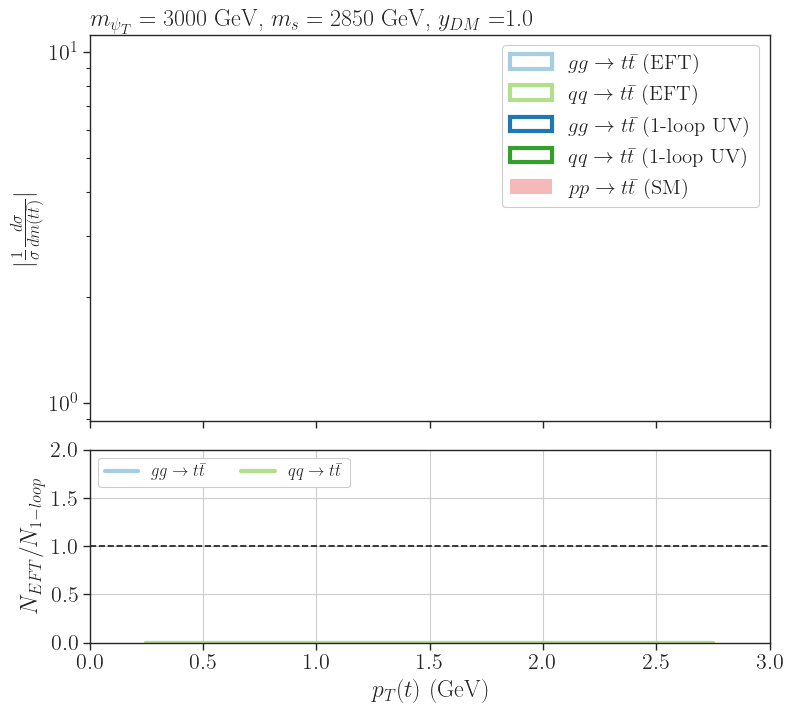

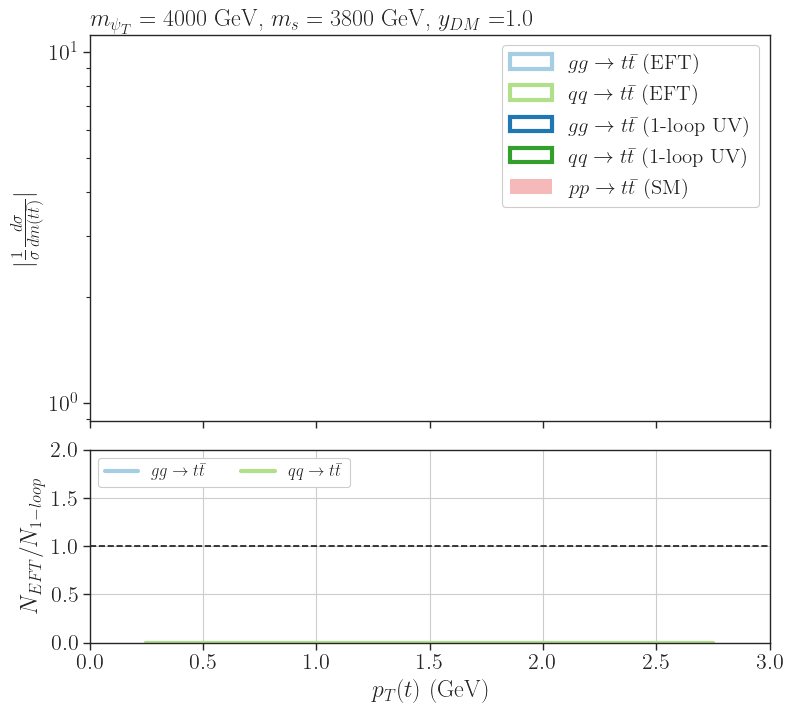

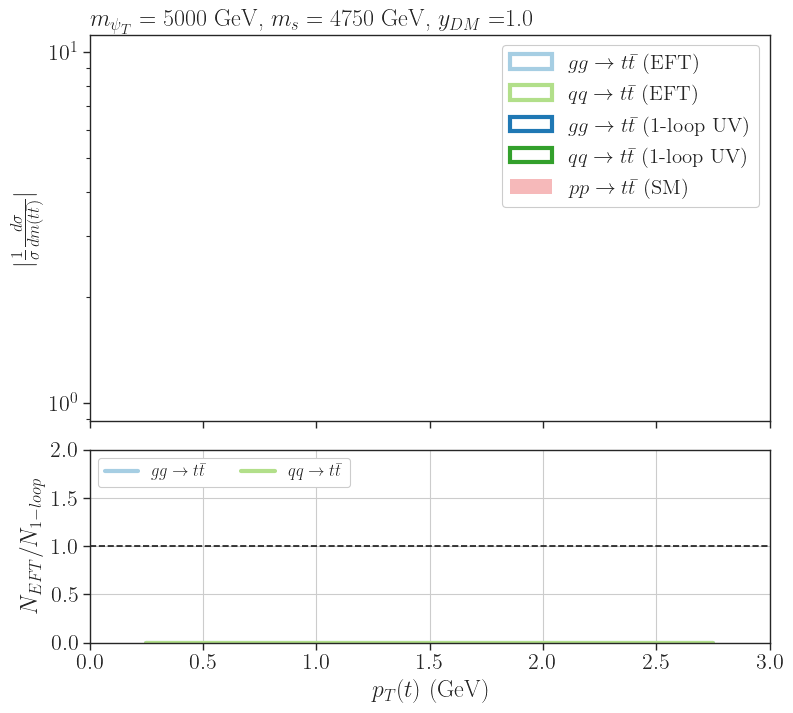

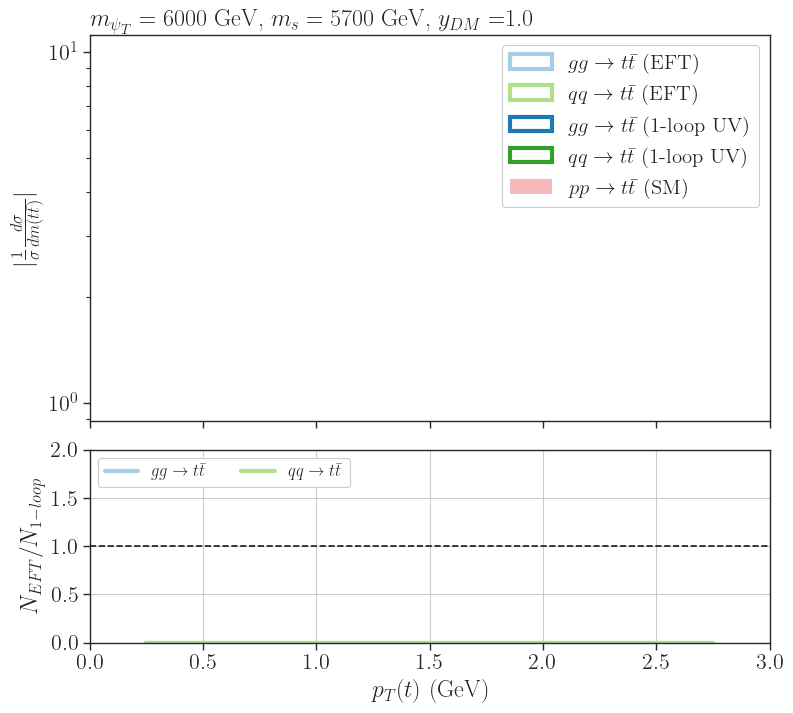

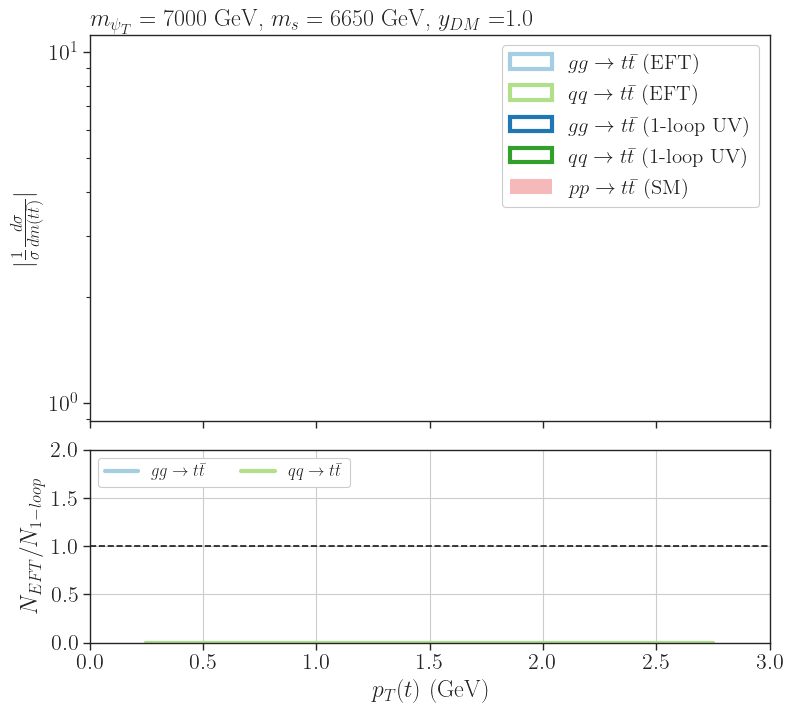

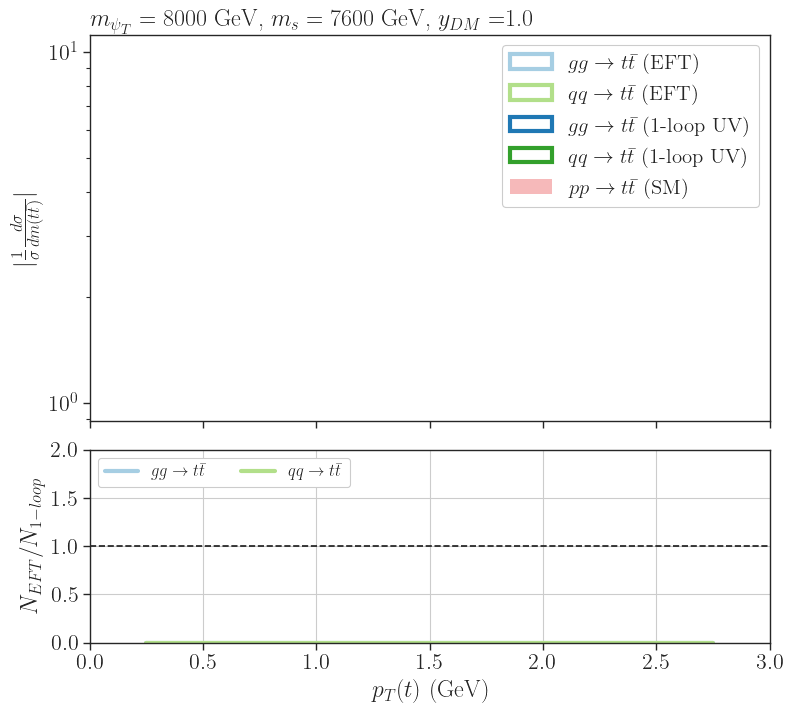

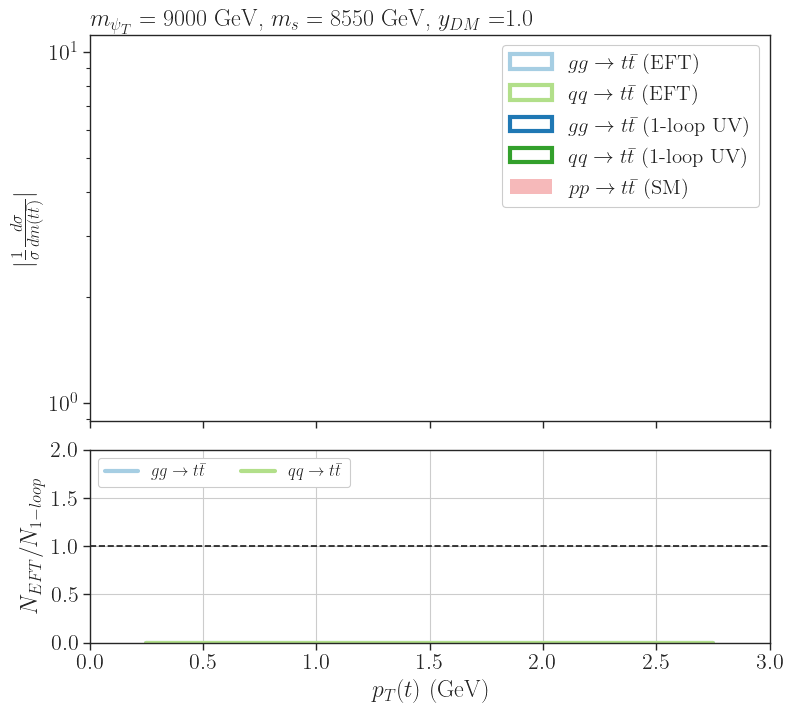

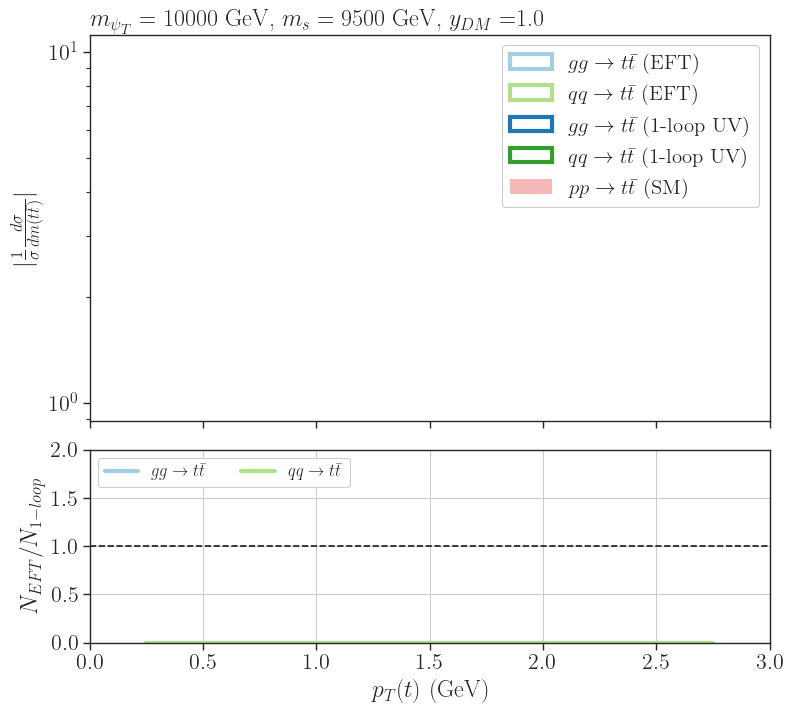

In [157]:
#Generating the BSM histograms and plotting them
bins = np.arange(0,np.pi,0.5)
# Coupling value
yDM = 1.0

#Loop over the masses configurations. Each mass configuration has 2 models with 2 processes each
for i in range(0, len(data), 4):
    #Selecting the models and process for the same mass configuration
    selected = data[i : i+4]

    #Defining the space for the two plots 
    _, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

    #Variables used to store hist info
    labels = []
    pmodels = []
    hists = []
    histsErr = []
    c = []
    mPsiT,mSDM = selected[0]['mass_params']

    #Loop over the processes and models
    for j,d in enumerate(selected):
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['deltaPhi'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['deltaPhi'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                          color=c[j],alpha=1.0,histtype='step',density=True,
                         linewidth=3,fill=False,zorder=i,linestyle='solid')
    #Plotting the SM hist
    axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[5],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    #Ratio plot
    # Separating the EFT and the 1-loop UV results
    hLoop = hists[2:]
    hEFT = hists[:2]
    #Computing the ratio EFT/1-loop UV
    labels_r = [r'$g g \to t \bar{t}$', r'$q q \to t \bar{t}$']
    for j,h in enumerate(hLoop):
        ratio = np.divide(hEFT[j]/sum(hEFT[j]) , h/sum(h), out=np.zeros_like(h),where=h != 0)
        #ratio = hEFT[j]- h
        # Remove zero values
        #nonzero = np.where((np.sign(ratio) != 0))
        x = (bins[:-1]+bins[1:])/2.0
        y = ratio
        label = labels_r[j]
        #Ratio plots
        axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[j])
        
    #Main plot configs
    axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
    axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    axarr[0].set_xlim(bins.min(),bins.max())
    axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
    #Subplot configs
    axarr[1].set_ylim(0.0,2)
    #axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
    #axarr[1].set_yscale('log')
    axarr[1].grid()
    axarr[1].axhline(y=1, color='k', linestyle='--')
    axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
    axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
    
plt.show()